# Hyperparameter Optimization (HPO) of Machine Learning Models

### **Sample code for classification problems**  
**Dataset used:**  
&nbsp; blood transfusion service center

**Machine learning algorithms used:**  
&nbsp; Random forest (RF), support vector machine (SVM), k-nearest neighbor (KNN), artificial neural network (ANN)

**HPO algorithms used:**  
&nbsp; Grid search, random search, hyperband, Bayesian Optimization with Gaussian Processes (BO-GP), Bayesian Optimization with Tree-structured Parzen Estimator (BO-TPE), particle swarm optimization (PSO), genetic algorithm (GA).

**Performance metric:**  
&nbsp; Classification accuracy

In [ ]:
import os

def install_packages(packages):
    for package in packages:
        !pip install -q {package}

packages_to_install = [
    "tensorflow~=2.11",
    "scikeras",
    "keras",
    "seaborn",
    "Optunity",
    "sklearn-deap",
    "colorama",
    "scikit-optimize",
    "hyperopt",
    "tpot",
    "ipykernel",
    "jupyter",
    "scikeras[tensorflow]",
    "arff",
    "tqdm",
    "ucimlrepo"
]

install_packages(packages_to_install)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import time
import optunity
import optunity.metrics
import keras
import sys
import urllib.request
import arff
import os
import torch
import torchvision
import torchvision.transforms as transforms
from tpot import TPOTClassifier
from random import randint
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,make_scorer, recall_score, f1_score, precision_score, log_loss
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC,SVR
from sklearn.neighbors import KNeighborsClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import parallel_backend
from sklearn import datasets
from random import randrange as sp_randrange
from scipy.stats import randint as sp_randint
from pandas import read_csv
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPClassifier
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV
from random import randrange as sp_randrange
from sklearn.neural_network import MLPRegressor
from skopt import Optimizer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm

2024-11-07 12:09:00.909275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 12:09:01.008161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 12:09:01.031192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 12:09:01.114315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 12:09:07.195665: W tensorflow/compiler/tf2

## Load dataset


In [ ]:
# fetch dataset
blood_transfusion_service_center = fetch_ucirepo(id=176)

# data (as pandas dataframes)
X = blood_transfusion_service_center.data.features
y = blood_transfusion_service_center.data.targets

# metadata
print(blood_transfusion_service_center.metadata)

# variable information
print(blood_transfusion_service_center.variables)

print(X)
print(y)

{'uci_id': 176, 'name': 'Blood Transfusion Service Center', 'repository_url': 'https://archive.ics.uci.edu/dataset/176/blood+transfusion+service+center', 'data_url': 'https://archive.ics.uci.edu/static/public/176/data.csv', 'abstract': 'Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan -- this is a classification problem. ', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 748, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Donated_Blood'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C5GS39', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 434, 'type': 'NATIVE', 'title': 'Knowledge discovery on RFM model using Bernoulli sequence', 'authors': 'I. Yeh, K. Yang, Tao-Ming Ting', 'venue': 'Expert systems with applications', 'year': 2009, 'journa

**Preprocessing**

In [ ]:
import numpy as np
from collections import Counter

y_values = y.values.ravel()

#The target attribute is a binary variable representing whether he/she donated blood in March 2007 (2 stands for donating blood; 1 stands for not donating blood).
class_names = {0: "Non ha donato", 1: "Ha donato"}

class_counts = Counter(y_values)
total_samples = len(y_values)

print("Analisi del bilancio delle classi per il dataset di donazione di sangue:")
print("---------------------------------------------------------------------")
for class_label, count in class_counts.items():
    percentage = (count / total_samples) * 100
    class_name = class_names[class_label]
    print(f"Classe {class_label} ({class_name}): {count} campioni ({percentage:.2f}%)")

print(f"\nCampioni totali: {total_samples}")

# Rapporto di sbilanciamento
if len(class_counts) == 2:
    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)
    imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]
    print(f"\nRapporto di sbilanciamento ({class_names[majority_class]}:{class_names[minority_class]}): {imbalance_ratio:.2f}:1")

Analisi del bilancio delle classi per il dataset di donazione di sangue:
---------------------------------------------------------------------
Classe 1 (Ha donato): 178 campioni (23.80%)
Classe 0 (Non ha donato): 570 campioni (76.20%)

Campioni totali: 748

Rapporto di sbilanciamento (Non ha donato:Ha donato): 3.20:1


In [ ]:
def analyze_feature_balance(X, feature_name):
    if X[feature_name].dtype in ['int64', 'float64']:
        # Per feature numeriche
        bins = pd.cut(X[feature_name], bins=5)
        counts = bins.value_counts().sort_index()
        total = len(X)
        print(f"\nDistribuzione della feature '{feature_name}':")
        for bin_range, count in counts.items():
            percentage = (count / total) * 100
            print(f"  {bin_range}: {count} campioni ({percentage:.2f}%)")
    else:
        # Per feature categoriche
        counts = X[feature_name].value_counts()
        total = len(X)
        print(f"\nDistribuzione della feature '{feature_name}':")
        for value, count in counts.items():
            percentage = (count / total) * 100
            print(f"  {value}: {count} campioni ({percentage:.2f}%)")

# Analisi del dataset della donazione di sangue
blood_donation = fetch_ucirepo(id=176)
X_blood = blood_donation.data.features
print("\n\nAnalisi del bilanciamento delle feature per il dataset della donazione di sangue:")
print("--------------------------------------------------------------------------------")
for column in X_blood.columns:
    analyze_feature_balance(X_blood, column)



Analisi del bilanciamento delle feature per il dataset della donazione di sangue:
--------------------------------------------------------------------------------

Distribuzione della feature 'Recency':
  (-0.074, 14.8]: 575 campioni (76.87%)
  (14.8, 29.6]: 166 campioni (22.19%)
  (29.6, 44.4]: 5 campioni (0.67%)
  (44.4, 59.2]: 0 campioni (0.00%)
  (59.2, 74.0]: 2 campioni (0.27%)

Distribuzione della feature 'Frequency':
  (0.951, 10.8]: 645 campioni (86.23%)
  (10.8, 20.6]: 86 campioni (11.50%)
  (20.6, 30.4]: 9 campioni (1.20%)
  (30.4, 40.2]: 3 campioni (0.40%)
  (40.2, 50.0]: 5 campioni (0.67%)

Distribuzione della feature 'Monetary':
  (237.75, 2700.0]: 645 campioni (86.23%)
  (2700.0, 5150.0]: 86 campioni (11.50%)
  (5150.0, 7600.0]: 9 campioni (1.20%)
  (7600.0, 10050.0]: 3 campioni (0.40%)
  (10050.0, 12500.0]: 5 campioni (0.67%)

Distribuzione della feature 'Time':
  (1.904, 21.2]: 268 campioni (35.83%)
  (21.2, 40.4]: 236 campioni (31.55%)
  (40.4, 59.6]: 119 campioni (1

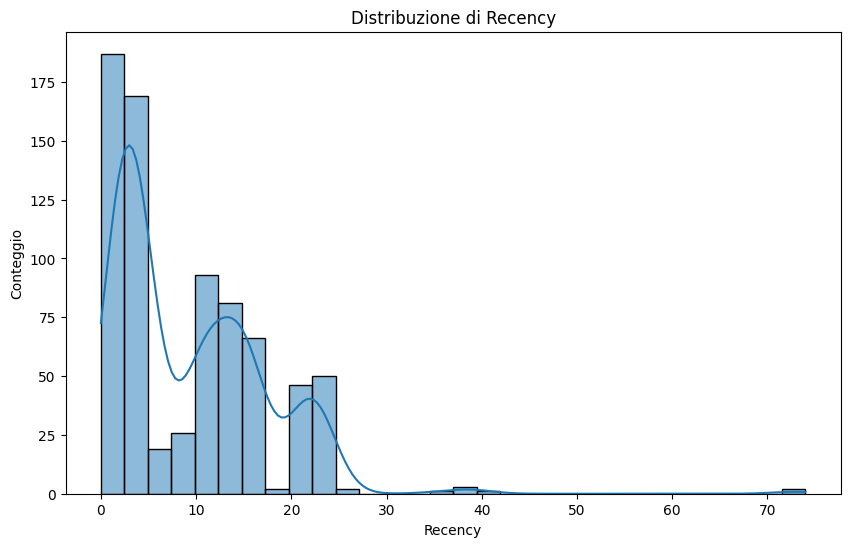

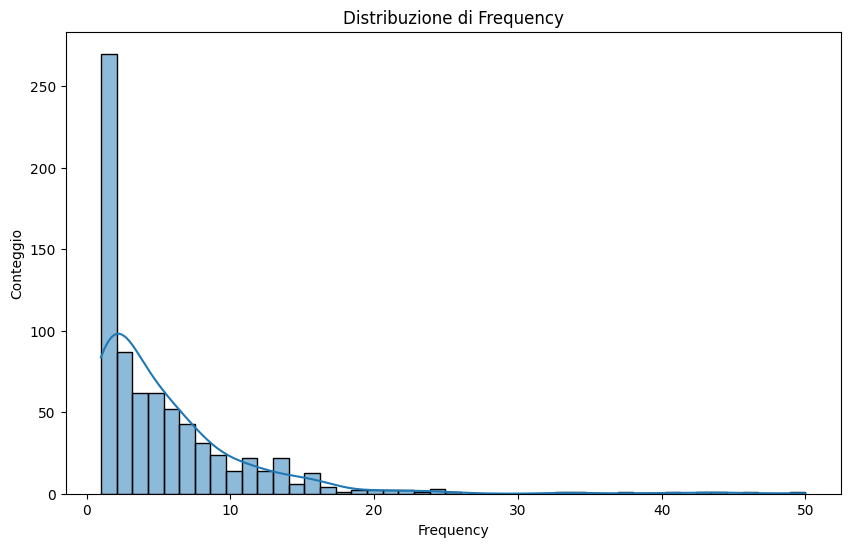

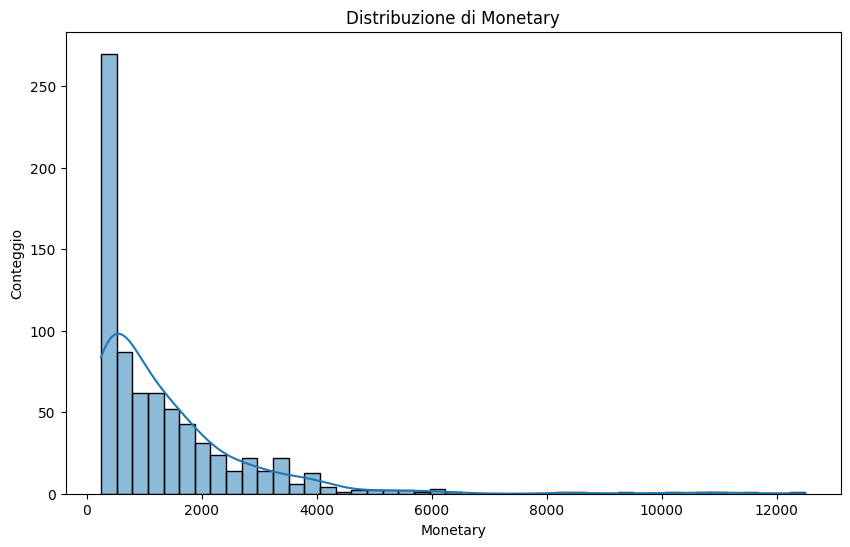

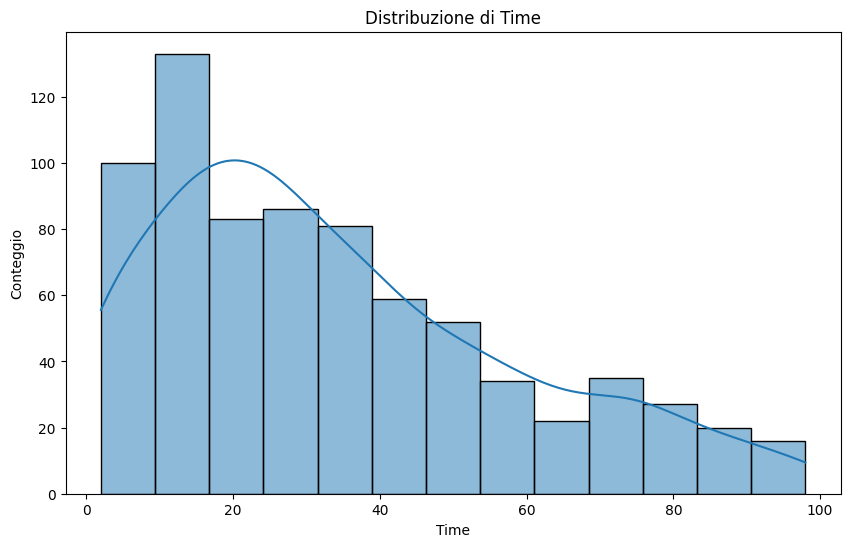


Legenda per l'interpretazione degli indici:
# Skewness = 0: Distribuzione perfettamente simmetrica.
# Skewness > 0: Sbilanciamento verso destra (coda lunga a destra).
# Skewness < 0: Sbilanciamento verso sinistra (coda lunga a sinistra).
# Kurtosis ≈ 3: Distribuzione normale (mesocurtica).
# Kurtosis > 3: Code più pronunciate (leptocurtica).
# Kurtosis < 3: Code meno pronunciate (platicurtica).
# CV < 10%: Distribuzione molto bilanciata.
# CV > 50%: Distribuzione altamente sbilanciata.

Tabella riassuntiva degli indici per le feature numeriche:
               Gini   Kurtosis  Skewness      CV (%)
Frequency  0.478150  15.762216  3.204822  105.815299
Monetary   0.478150  15.762216  3.204822  105.815299
Recency    0.439091   9.320679  1.876690   85.097833
Time       0.395629  -0.252003  0.747947   71.058729


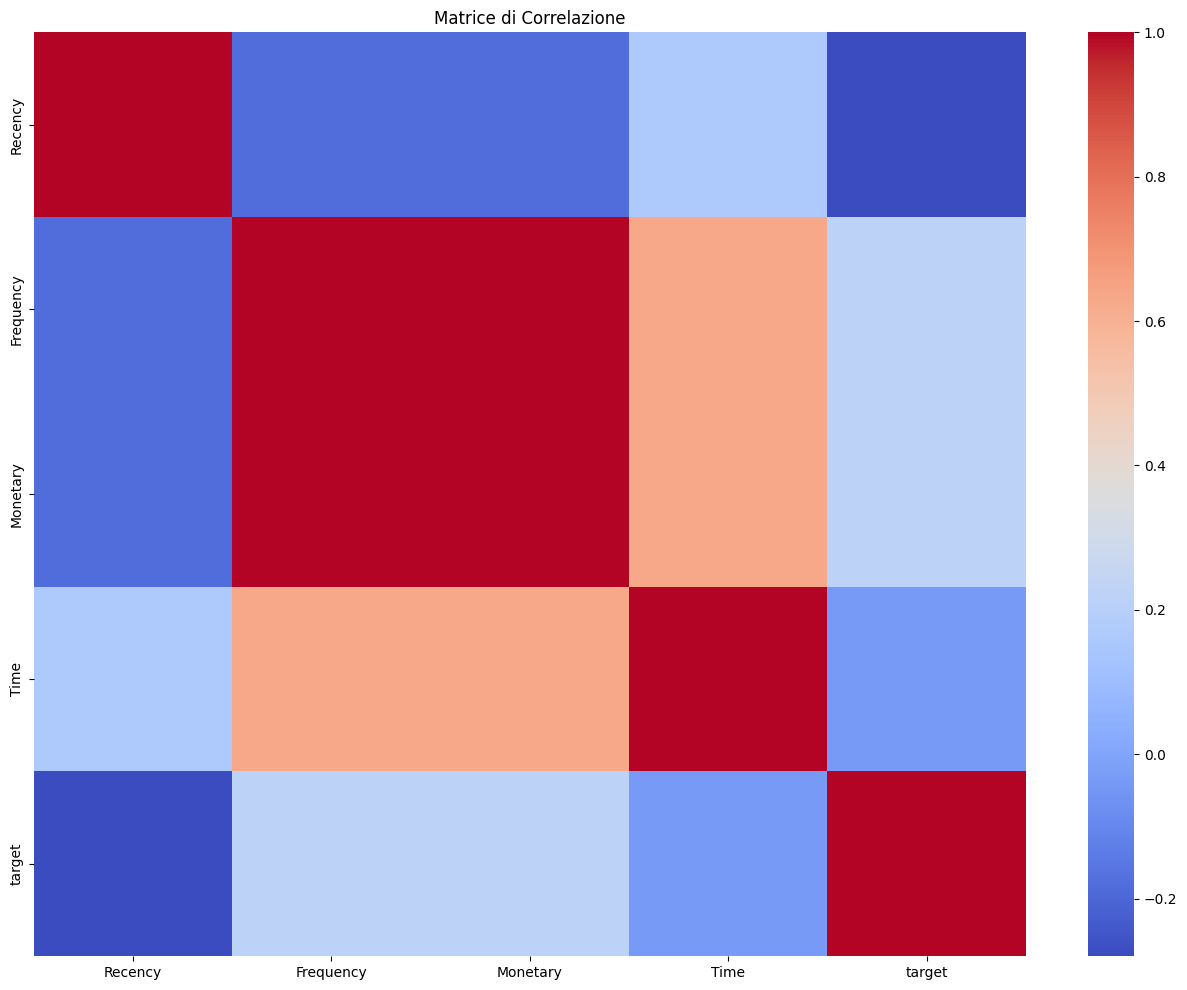

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

# Funzioni di analisi
def plot_numerical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribuzione di {column}')
    plt.xlabel(column)
    plt.ylabel('Conteggio')
    plt.show()

def calculate_gini(array):
    array = np.sort(array)
    index = np.arange(1, len(array) + 1)
    n = len(array)
    if np.sum(array) == 0:
        return np.nan  # Evita divisioni per zero
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

def calculate_cv(array):
    mean = np.mean(array)
    if mean == 0:
        return np.nan  # Evita divisioni per zero
    return np.std(array) / mean * 100

# Caricamento del dataset
# Assuming 'X' è il DataFrame delle features e 'y' è il target
df = pd.DataFrame(X)
df['target'] = y  # Aggiunge la colonna target per l'analisi

# Calcolo degli indici per le variabili numeriche
numerical_columns = df.columns
summary_stats = {}

for col in numerical_columns:
    if col != 'target':  # Escludiamo la colonna target
        data = df[col].dropna().values
        if len(data) > 0:
            summary_stats[col] = {
                'Gini': calculate_gini(data),
                'Kurtosis': kurtosis(data, nan_policy='omit'),
                'Skewness': skew(data, nan_policy='omit'),
                'CV (%)': calculate_cv(data)
            }
            plot_numerical_distribution(df, col)

# Creazione della tabella riassuntiva
summary_df = pd.DataFrame.from_dict(summary_stats, orient='index')
summary_df = summary_df.sort_values('Gini', ascending=False)

# Legenda per l'interpretazione
print("\nLegenda per l'interpretazione degli indici:")
print("# Skewness = 0: Distribuzione perfettamente simmetrica.")
print("# Skewness > 0: Sbilanciamento verso destra (coda lunga a destra).")
print("# Skewness < 0: Sbilanciamento verso sinistra (coda lunga a sinistra).")
print("# Kurtosis ≈ 3: Distribuzione normale (mesocurtica).")
print("# Kurtosis > 3: Code più pronunciate (leptocurtica).")
print("# Kurtosis < 3: Code meno pronunciate (platicurtica).")
print("# CV < 10%: Distribuzione molto bilanciata.")
print("# CV > 50%: Distribuzione altamente sbilanciata.")

print("\nTabella riassuntiva degli indici per le feature numeriche:")
print(summary_df)

# Matrice di correlazione
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Matrice di Correlazione')
plt.show()


In [ ]:
# Step 1: Importa SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X= X_scaled

# Step 2: Suddividi il dataset in training e test set
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Applica SMOTE per bilanciare le classi nel training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Controlla la nuova distribuzione delle classi
from collections import Counter
print("Distribuzione delle classi dopo SMOTE:", Counter(y_train_bal))

# Continua con il training del modello usando i dati bilanciati
# esempio: addestramento di un modello di classificazione
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

# Valutazione del modello sui dati di test
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

X= X_train_bal
y= y_train_bal

Distribuzione delle classi dopo SMOTE: Counter({0: 399, 1: 399})
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       171
           1       0.41      0.50      0.45        54

    accuracy                           0.71       225
   macro avg       0.62      0.64      0.62       225
weighted avg       0.73      0.71      0.72       225



In [ ]:
# # Converti y in un array unidimensionale
# y = np.ravel(y)

# # Standardizzazione delle feature
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Suddivisione del dataset in train e test
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42, stratify=y)

# X= X_train
# y= y_train
# print(X)
# print(y)

In [ ]:
num_classes = len(np.unique(y))
print(num_classes)

2


In [ ]:
#ANN
def ANN(optimizer='sgd', neurons=32, batch_size=32, epochs=20, activation='relu', patience=3, loss='sparse_categorical_crossentropy'):
    num_classes = len(np.unique(y))
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))  # Usiamo Input(shape) come primo livello
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss)
    early_stopping = EarlyStopping(monitor="loss", patience=patience)  # early stop patience
    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[early_stopping],
                        verbose=1)  # verbose impostato su 1 mostrerà il processo di addestramento
    return model

## Baseline Machine Learning Models: Classifiers with Default Hyperparameters

### Using 3-Fold Cross-Validation

In [ ]:
# Definire i punteggi per log_loss
log_loss_scorer = make_scorer(log_loss, labels=np.unique(y), response_method='predict_proba')

# Scorers con precision aggiunto
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'log_loss': log_loss_scorer
}

results_classification = []

# Random Forest
start_time_rf = time.time()
clf_rf = RandomForestClassifier(n_jobs=-1)
scores_rf = cross_validate(clf_rf, X, y, cv=3, scoring=scorers, verbose=3)
elapsed_time_rf = round(time.time() - start_time_rf, 2)
results_classification.append({
    'Algorithm': 'Random Forest',
    'Accuracy': scores_rf['test_accuracy'].mean(),
    'Recall': scores_rf['test_recall'].mean(),
    'Precision': scores_rf['test_precision'].mean(),
    'F1 Score': scores_rf['test_f1'].mean(),
    'Log Loss': scores_rf['test_log_loss'].mean(),
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
start_time_svm = time.time()
clf_svm = SVC(probability=True)
scores_svm = cross_validate(clf_svm, X, y, cv=3, scoring=scorers, verbose=3)
elapsed_time_svm = round(time.time() - start_time_svm, 2)
results_classification.append({
    'Algorithm': 'SVM',
    'Accuracy': scores_svm['test_accuracy'].mean(),
    'Recall': scores_svm['test_recall'].mean(),
    'Precision': scores_svm['test_precision'].mean(),
    'F1 Score': scores_svm['test_f1'].mean(),
    'Log Loss': scores_svm['test_log_loss'].mean(),
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
start_time_knn = time.time()
clf_knn = KNeighborsClassifier()
scores_knn = cross_validate(clf_knn, X, y, cv=3, scoring=scorers, verbose=3)
elapsed_time_knn = round(time.time() - start_time_knn, 2)
results_classification.append({
    'Algorithm': 'KNN',
    'Accuracy': scores_knn['test_accuracy'].mean(),
    'Recall': scores_knn['test_recall'].mean(),
    'Precision': scores_knn['test_precision'].mean(),
    'F1 Score': scores_knn['test_f1'].mean(),
    'Log Loss': scores_knn['test_log_loss'].mean(),
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
start_time_ann = time.time()
clf_ann = KerasClassifier(model=ANN, verbose=0)
scores_ann = cross_validate(clf_ann, X, y, cv=3, scoring=scorers)
elapsed_time_ann = round(time.time() - start_time_ann, 2)
results_classification.append({
    'Algorithm': 'ANN',
    'Accuracy': scores_ann['test_accuracy'].mean(),
    'Recall': scores_ann['test_recall'].mean(),
    'Precision': scores_ann['test_precision'].mean(),
    'F1 Score': scores_ann['test_f1'].mean(),
    'Log Loss': scores_ann['test_log_loss'].mean(),
    'Time Elapsed (s)': elapsed_time_ann
})

# Creazione DataFrame e visualizzazione risultati
results_df_3_fold_classification = pd.DataFrame(results_classification)
print("\nResults for Classification Models (3-Fold Cross-Validation):")
print(results_df_3_fold_classification.to_string(index=False))

[CV] END  accuracy: (test=0.711) f1: (test=0.704) log_loss: (test=1.130) precision: (test=0.730) recall: (test=0.711) total time=   1.0s
[CV] END  accuracy: (test=0.842) f1: (test=0.841) log_loss: (test=0.426) precision: (test=0.850) recall: (test=0.842) total time=   0.8s
[CV] END  accuracy: (test=0.853) f1: (test=0.853) log_loss: (test=0.339) precision: (test=0.854) recall: (test=0.853) total time=   1.2s
[CV] END  accuracy: (test=0.692) f1: (test=0.690) log_loss: (test=0.587) precision: (test=0.695) recall: (test=0.692) total time=   0.3s
[CV] END  accuracy: (test=0.718) f1: (test=0.718) log_loss: (test=0.571) precision: (test=0.718) recall: (test=0.718) total time=   0.5s
[CV] END  accuracy: (test=0.680) f1: (test=0.675) log_loss: (test=0.572) precision: (test=0.692) recall: (test=0.680) total time=   0.4s
[CV] END  accuracy: (test=0.722) f1: (test=0.721) log_loss: (test=2.183) precision: (test=0.726) recall: (test=0.722) total time=   0.2s
[CV] END  accuracy: (test=0.722) f1: (tes

## HPO Algorithm 1: Grid Search
Search all the given hyper-parameter configurations

**Advantages:**
* Simple implementation.  

**Disadvantages:**  
* Time-consuming,
* Only efficient with categorical HPs.

In [ ]:
# Definire i punteggi per log_loss
log_loss_scorer = make_scorer(log_loss, labels=np.unique(y), response_method='predict_proba')

# Scorers con precision aggiunto
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'log_loss': log_loss_scorer
}

results_classification_grid_search = []

# Random Forest
start_time_rf = time.time()
rf_params = {
    'n_estimators': [10, 20, 30],
    'max_depth': [15, 20, 30, 50],
    'criterion': ['gini', 'entropy']
}
clf_rf = RandomForestClassifier(random_state=0)
grid_rf = GridSearchCV(clf_rf, rf_params, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
grid_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time_rf, 2)
results_classification_grid_search.append({
    'Algorithm': 'Random Forest',
    'Best Params': grid_rf.best_params_,
    'Accuracy': grid_rf.best_score_,
    'Recall': grid_rf.cv_results_['mean_test_recall'][grid_rf.best_index_],
    'Precision': grid_rf.cv_results_['mean_test_precision'][grid_rf.best_index_],
    'F1 Score': grid_rf.cv_results_['mean_test_f1'][grid_rf.best_index_],
    'Log Loss': grid_rf.cv_results_['mean_test_log_loss'][grid_rf.best_index_],
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
start_time_svm = time.time()
svm_params = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
clf_svm = SVC(gamma='scale', probability=True)
grid_svm = GridSearchCV(clf_svm, svm_params, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
grid_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time_svm, 2)
results_classification_grid_search.append({
    'Algorithm': 'SVM',
    'Best Params': grid_svm.best_params_,
    'Accuracy': grid_svm.best_score_,
    'Recall': grid_svm.cv_results_['mean_test_recall'][grid_svm.best_index_],
    'Precision': grid_svm.cv_results_['mean_test_precision'][grid_svm.best_index_],
    'F1 Score': grid_svm.cv_results_['mean_test_f1'][grid_svm.best_index_],
    'Log Loss': grid_svm.cv_results_['mean_test_log_loss'][grid_svm.best_index_],
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
start_time_knn = time.time()
knn_params = {
    'n_neighbors': [2, 3, 5, 10, 15, 20],
}
clf_knn = KNeighborsClassifier()
grid_knn = GridSearchCV(clf_knn, knn_params, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
grid_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time_knn, 2)
results_classification_grid_search.append({
    'Algorithm': 'KNN',
    'Best Params': grid_knn.best_params_,
    'Accuracy': grid_knn.best_score_,
    'Recall': grid_knn.cv_results_['mean_test_recall'][grid_knn.best_index_],
    'Precision': grid_knn.cv_results_['mean_test_precision'][grid_knn.best_index_],
    'F1 Score': grid_knn.cv_results_['mean_test_f1'][grid_knn.best_index_],
    'Log Loss': grid_knn.cv_results_['mean_test_log_loss'][grid_knn.best_index_],
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
start_time_ann = time.time()
ann_params = {
    'batch_size': [16, 32],
    'epochs': [20, 50],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation': ['relu', 'tanh']
}

clf_ann = KerasClassifier(model=ANN, activation='relu', neurons=16, patience=2, verbose=0)
grid_ann = GridSearchCV(clf_ann, ann_params, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
grid_ann.fit(X, y)
elapsed_time_ann = round(time.time() - start_time_ann, 2)
results_classification_grid_search.append({
    'Algorithm': 'ANN',
    'Best Params': grid_ann.best_params_,
    'Accuracy': grid_ann.best_score_,
    'Recall': grid_ann.cv_results_['mean_test_recall'][grid_ann.best_index_],
    'Precision': grid_ann.cv_results_['mean_test_precision'][grid_ann.best_index_],
    'F1 Score': grid_ann.cv_results_['mean_test_f1'][grid_ann.best_index_],
    'Log Loss': grid_ann.cv_results_['mean_test_log_loss'][grid_ann.best_index_],
    'Time Elapsed (s)': elapsed_time_ann
})

# Creazione DataFrame e visualizzazione risultati
results_classification_df_grid_search = pd.DataFrame(results_classification_grid_search)
print("Results for Grid Search")
print(results_classification_df_grid_search.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7639  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7055 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6839 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6764 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6623 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6672 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6522 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6497 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6446 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6410
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6500 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6315 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6286  
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6315 
Ep

## HPO Algorithm 2: Random Search
Randomly search hyper-parameter combinations in the search space

**Advantages:**
* More efficient than GS.
* Enable parallelization.

**Disadvantages:**  
* Not consider previous results.
* Not efficient with conditional HPs.

In [ ]:
# Definire i punteggi per log_loss con zero_division
log_loss_scorer = make_scorer(log_loss, labels=np.unique(y), response_method='predict_proba')
precision_scorer = make_scorer(precision_score, average='macro', zero_division=1)
recall_scorer = make_scorer(recall_score, average='macro')
f1_scorer = make_scorer(f1_score, average='macro')

# Scorers con precision aggiunto
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': recall_scorer,
    'precision': precision_scorer,
    'f1': f1_scorer,
    'log_loss': log_loss_scorer
}

results_classification_random_search = []

# Random Forest
start_time_rf = time.time()
rf_params = {
    'n_estimators': sp_randint(10, 100),
    'max_features': sp_randint(1, 64),
    'max_depth': sp_randint(5, 50),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'criterion': ['gini', 'entropy']
}
n_iter_search_rf = 20  # Number of iterations
clf_rf = RandomForestClassifier(random_state=0)
Random_rf = RandomizedSearchCV(clf_rf, param_distributions=rf_params, n_iter=n_iter_search_rf, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
Random_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time_rf, 2)
results_classification_random_search.append({
    'Algorithm': 'Random Forest',
    'Best Params': Random_rf.best_params_,
    'Accuracy': Random_rf.best_score_,
    'Recall': Random_rf.cv_results_['mean_test_recall'][Random_rf.best_index_],
    'Precision': Random_rf.cv_results_['mean_test_precision'][Random_rf.best_index_],
    'F1 Score': Random_rf.cv_results_['mean_test_f1'][Random_rf.best_index_],
    'Log Loss': Random_rf.cv_results_['mean_test_log_loss'][Random_rf.best_index_],
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
start_time_svm = time.time()
svm_params = {
    'C': uniform(0, 50),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
n_iter_search_svm = 20
clf_svm = SVC(gamma='scale', probability=True)
Random_svm = RandomizedSearchCV(clf_svm, param_distributions=svm_params, n_iter=n_iter_search_svm, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
Random_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time_svm, 2)
results_classification_random_search.append({
    'Algorithm': 'SVM',
    'Best Params': Random_svm.best_params_,
    'Accuracy': Random_svm.best_score_,
    'Recall': Random_svm.cv_results_['mean_test_recall'][Random_svm.best_index_],
    'Precision': Random_svm.cv_results_['mean_test_precision'][Random_svm.best_index_],
    'F1 Score': Random_svm.cv_results_['mean_test_f1'][Random_svm.best_index_],
    'Log Loss': Random_svm.cv_results_['mean_test_log_loss'][Random_svm.best_index_],
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
start_time_knn = time.time()
knn_params = {
    'n_neighbors': range(1, 20),
}
n_iter_search_knn = 10
clf_knn = KNeighborsClassifier()
Random_knn = RandomizedSearchCV(clf_knn, param_distributions=knn_params, n_iter=n_iter_search_knn, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
Random_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time_knn, 2)
results_classification_random_search.append({
    'Algorithm': 'KNN',
    'Best Params': Random_knn.best_params_,
    'Accuracy': Random_knn.best_score_,
    'Recall': Random_knn.cv_results_['mean_test_recall'][Random_knn.best_index_],
    'Precision': Random_knn.cv_results_['mean_test_precision'][Random_knn.best_index_],
    'F1 Score': Random_knn.cv_results_['mean_test_f1'][Random_knn.best_index_],
    'Log Loss': Random_knn.cv_results_['mean_test_log_loss'][Random_knn.best_index_],
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
start_time_ann = time.time()
ann_params = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'neurons': sp_randint(10, 100),
    'epochs': [20, 50],
    'patience': sp_randint(3, 20)
}
n_iter_search_ann = 10
clf_ann = KerasClassifier(model=ANN, activation='relu', neurons=10, patience=6, verbose=0)
Random_ann = RandomizedSearchCV(clf_ann, param_distributions=ann_params, n_iter=n_iter_search_ann, cv=3, scoring=scorers, refit='accuracy', return_train_score=True)
Random_ann.fit(X, y)
elapsed_time_ann = round(time.time() - start_time_ann, 2)
results_classification_random_search.append({
    'Algorithm': 'ANN',
    'Best Params': Random_ann.best_params_,
    'Accuracy': Random_ann.best_score_,
    'Recall': Random_ann.cv_results_['mean_test_recall'][Random_ann.best_index_],
    'Precision': Random_ann.cv_results_['mean_test_precision'][Random_ann.best_index_],
    'F1 Score': Random_ann.cv_results_['mean_test_f1'][Random_ann.best_index_],
    'Log Loss': Random_ann.cv_results_['mean_test_log_loss'][Random_ann.best_index_],
    'Time Elapsed (s)': elapsed_time_ann
})

# Creazione DataFrame e visualizzazione risultati
results_classification_df_random_search = pd.DataFrame(results_classification_random_search)
print("Results for Random Search")
print(results_classification_df_random_search.to_string(index=False))

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6652  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6490 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6395
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6254 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6322
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6197 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5983  
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6248 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6021
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6056
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5875
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5836
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6022
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5850
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5821
Epoch 16/20

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6607  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6410 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6306 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6298 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6068  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6137 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5989 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6011
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6046
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6022 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5963 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6032
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5952 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6032
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5818 
Epoch 16/20
25/25

## HPO Algorithm 3: BO-GP
Bayesian Optimization with Gaussian Process (BO-GP)

**Advantages:**
* Fast convergence speed for continuous HPs.  

**Disadvantages:**  
* Poor capacity for parallelization.
* Not efficient with conditional HPs.

### Using skopt.BayesSearchCV

In [ ]:
# Definire i punteggi per log_loss
log_loss_scorer = make_scorer(log_loss, labels=np.unique(y), response_method='predict_proba')

# Scorers con precision aggiunto
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'log_loss': log_loss_scorer
}

results_classification_bo = []

# Random Forest
start_time_rf = time.time()
rf_params = {
    'n_estimators': Integer(10, 100),
    'max_features': Integer(1, 64),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 11),
    'min_samples_leaf': Integer(1, 11),
    'criterion': ['gini', 'entropy']
}
clf_rf = RandomForestClassifier(random_state=0)
with parallel_backend('threading'):
    Bayes_rf = BayesSearchCV(clf_rf, rf_params, cv=3, n_iter=20, n_jobs=-1, scoring=scorers, refit='accuracy', return_train_score=True)
    Bayes_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time_rf, 2)
results_classification_bo.append({
    'Algorithm': 'Random Forest',
    'Best Params': Bayes_rf.best_params_,
    'Accuracy': Bayes_rf.best_score_,
    'Recall': Bayes_rf.cv_results_['mean_test_recall'][Bayes_rf.best_index_],
    'Precision': Bayes_rf.cv_results_['mean_test_precision'][Bayes_rf.best_index_],
    'F1 Score': Bayes_rf.cv_results_['mean_test_f1'][Bayes_rf.best_index_],
    'Log Loss': Bayes_rf.cv_results_['mean_test_log_loss'][Bayes_rf.best_index_],
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
start_time_svm = time.time()
svm_params = {
    'C': Real(0.01, 50),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
clf_svm = SVC(gamma='scale', probability=True)
with parallel_backend('threading'):
    Bayes_svm = BayesSearchCV(clf_svm, svm_params, cv=3, n_iter=20, n_jobs=-1, scoring=scorers, refit='accuracy', return_train_score=True)
    Bayes_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time_svm, 2)
results_classification_bo.append({
    'Algorithm': 'SVM',
    'Best Params': Bayes_svm.best_params_,
    'Accuracy': Bayes_svm.best_score_,
    'Recall': Bayes_svm.cv_results_['mean_test_recall'][Bayes_svm.best_index_],
    'Precision': Bayes_svm.cv_results_['mean_test_precision'][Bayes_svm.best_index_],
    'F1 Score': Bayes_svm.cv_results_['mean_test_f1'][Bayes_svm.best_index_],
    'Log Loss': Bayes_svm.cv_results_['mean_test_log_loss'][Bayes_svm.best_index_],
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
start_time_knn = time.time()
knn_params = {
    'n_neighbors': Integer(1, 20),
}
clf_knn = KNeighborsClassifier()
with parallel_backend('threading'):
    Bayes_knn = BayesSearchCV(clf_knn, knn_params, cv=3, n_iter=10, n_jobs=-1, scoring=scorers, refit='accuracy', return_train_score=True)
    Bayes_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time_knn, 2)
results_classification_bo.append({
    'Algorithm': 'KNN',
    'Best Params': Bayes_knn.best_params_,
    'Accuracy': Bayes_knn.best_score_,
    'Recall': Bayes_knn.cv_results_['mean_test_recall'][Bayes_knn.best_index_],
    'Precision': Bayes_knn.cv_results_['mean_test_precision'][Bayes_knn.best_index_],
    'F1 Score': Bayes_knn.cv_results_['mean_test_f1'][Bayes_knn.best_index_],
    'Log Loss': Bayes_knn.cv_results_['mean_test_log_loss'][Bayes_knn.best_index_],
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
start_time_ann = time.time()
ann_params = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'neurons': Integer(10, 100),
    'epochs': Categorical([20, 50]),
    'patience': Integer(3, 20)
}
clf_ann = KerasClassifier(model=ANN, activation='relu', neurons=10, patience=6, verbose=0)
with parallel_backend('threading'):
    Bayes_ann = BayesSearchCV(clf_ann, ann_params, cv=3, n_iter=10, scoring=scorers, refit='accuracy', return_train_score=True)
    Bayes_ann.fit(X, y)
elapsed_time_ann = round(time.time() - start_time_ann, 2)
results_classification_bo.append({
    'Algorithm': 'ANN',
    'Best Params': Bayes_ann.best_params_,
    'Accuracy': Bayes_ann.best_score_,
    'Recall': Bayes_ann.cv_results_['mean_test_recall'][Bayes_ann.best_index_],
    'Precision': Bayes_ann.cv_results_['mean_test_precision'][Bayes_ann.best_index_],
    'F1 Score': Bayes_ann.cv_results_['mean_test_f1'][Bayes_ann.best_index_],
    'Log Loss': Bayes_ann.cv_results_['mean_test_log_loss'][Bayes_ann.best_index_],
    'Time Elapsed (s)': elapsed_time_ann
})

# Creazione DataFrame e visualizzazione risultati
results_classification_df_bo = pd.DataFrame(results_classification_bo)
print("Results for Bayesian Optimization")
print(results_classification_df_bo.to_string(index=False))


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7020  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6969 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6800 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6621 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6590 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6500 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6445 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6359 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6300
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6243 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6203 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6155 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6208
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6034 
Epoch 

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7826  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6487 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6088  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5867 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5804 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6025  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5667 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5900
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5871
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6043 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6074 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5815 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5848 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5944 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6002
Epoch 16/20
25/

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6692
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6519
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6449 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6357 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6314 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6232 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6122  
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6221
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6179 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6050 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6099
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5951 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5990 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6146 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5921  
Epoch 

### Using skopt.gp_minimize

In [ ]:
# Definire i punteggi per log_loss
log_loss_scorer = make_scorer(log_loss, labels=np.unique(y), response_method='predict_proba')

# Scorers con precisione inclusa
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'log_loss': log_loss_scorer
}

results_classification_skopt_gp_minimize = []

def evaluate_metrics(model, X, y):
    """Evaluate multiple metrics and return them."""
    accuracy = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['accuracy']))
    recall = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['recall']))
    precision = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['precision']))
    f1 = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['f1']))
    log_loss_val = -np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['log_loss']))
    return accuracy, recall, precision, f1, log_loss_val

def composite_score(accuracy, recall, precision, f1, log_loss_val, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0):
    """Calculate a composite score from multiple metrics."""
    return - (alpha * accuracy + beta * recall + gamma * precision + delta * f1 + log_loss_val)

# Random Forest
start_time_rf = time.time()
reg_rf = RandomForestClassifier()

space_rf = [
    Integer(10, 100, name='n_estimators'),
    Integer(5, 50, name='max_depth'),
    Integer(1, 64, name='max_features'),
    Integer(2, 11, name='min_samples_split'),
    Integer(1, 11, name='min_samples_leaf'),
    Categorical(['gini', 'entropy'], name='criterion'),
]

@use_named_args(space_rf)
def objective_rf(**params):
    reg_rf.set_params(**params)
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(reg_rf, X, y)
    return composite_score(accuracy, recall, precision, f1, log_loss_val)

with parallel_backend('threading'):
    res_gp_rf = gp_minimize(objective_rf, space_rf, n_calls=20, random_state=0)

elapsed_time_rf = time.time() - start_time_rf
# Rebuild the model with the best parameters
best_rf = RandomForestClassifier(**dict(zip([dim.name for dim in space_rf], res_gp_rf.x)))
best_accuracy_rf, best_recall_rf, best_precision_rf, best_f1_rf, best_log_loss_rf = evaluate_metrics(best_rf, X, y)
results_classification_skopt_gp_minimize.append({
    'Algorithm': 'Random Forest',
    'Best Params': dict(zip([dim.name for dim in space_rf], res_gp_rf.x)),
    'Accuracy': best_accuracy_rf,
    'Recall': best_recall_rf,
    'Precision': best_precision_rf,
    'F1 Score': best_f1_rf,
    'Log Loss': -best_log_loss_rf,
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
start_time_svm = time.time()
reg_svm = SVC(gamma='scale', probability=True)

space_svm = [
    Real(0.01, 50, name='C'),
    Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'),
]

@use_named_args(space_svm)
def objective_svm(**params):
    reg_svm.set_params(**params)
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(reg_svm, X, y)
    return composite_score(accuracy, recall, precision, f1, log_loss_val)

with parallel_backend('threading'):
    res_gp_svm = gp_minimize(objective_svm, space_svm, n_calls=20, random_state=0)

elapsed_time_svm = time.time() - start_time_svm
# Rebuild the model with the best parameters
best_svm = SVC(**dict(zip([dim.name for dim in space_svm], res_gp_svm.x)), probability=True)
best_accuracy_svm, best_recall_svm, best_precision_svm, best_f1_svm, best_log_loss_svm = evaluate_metrics(best_svm, X, y)
results_classification_skopt_gp_minimize.append({
    'Algorithm': 'SVM',
    'Best Params': dict(zip([dim.name for dim in space_svm], res_gp_svm.x)),
    'Accuracy': best_accuracy_svm,
    'Recall': best_recall_svm,
    'Precision': best_precision_svm,
    'F1 Score': best_f1_svm,
    'Log Loss': -best_log_loss_svm,
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
start_time_knn = time.time()
reg_knn = KNeighborsClassifier()

space_knn = [Integer(1, 20, name='n_neighbors')]

@use_named_args(space_knn)
def objective_knn(**params):
    reg_knn.set_params(**params)
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(reg_knn, X, y)
    return composite_score(accuracy, recall, precision, f1, log_loss_val)

with parallel_backend('threading'):
    res_gp_knn = gp_minimize(objective_knn, space_knn, n_calls=10, random_state=0)

elapsed_time_knn = time.time() - start_time_knn
# Rebuild the model with the best parameters
best_knn = KNeighborsClassifier(**dict(zip([dim.name for dim in space_knn], res_gp_knn.x)))
best_accuracy_knn, best_recall_knn, best_precision_knn, best_f1_knn, best_log_loss_knn = evaluate_metrics(best_knn, X, y)
results_classification_skopt_gp_minimize.append({
    'Algorithm': 'KNN',
    'Best Params': dict(zip([dim.name for dim in space_knn], res_gp_knn.x)),
    'Accuracy': best_accuracy_knn,
    'Recall': best_recall_knn,
    'Precision': best_precision_knn,
    'F1 Score': best_f1_knn,
    'Log Loss': -best_log_loss_knn,
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
start_time_ann = time.time()
space_ann = [
    Categorical(['lbfgs', 'adam', 'sgd'], name='optimizer'),
    Categorical(['relu', 'tanh'], name='activation'),
    Integer(10, 100, name='neurons'),
    Integer(3, 20, name='patience'),
    Integer(16, 64, name='batch_size'),
    Categorical([20, 50], name='epochs'),
]

@use_named_args(space_ann)
def objective_ann(optimizer, activation, neurons, patience, batch_size, epochs):
    model = MLPClassifier(
        hidden_layer_sizes=(neurons,),
        activation=activation,
        solver=optimizer,
        batch_size=batch_size,
        max_iter=epochs,
        early_stopping=True,
        n_iter_no_change=patience,
        random_state=42
    )
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(model, X, y)
    return composite_score(accuracy, recall, precision, f1, log_loss_val)

with parallel_backend('threading'):
    res_gp_ann = gp_minimize(objective_ann, space_ann, n_calls=20, random_state=42, verbose=0)

elapsed_time_ann = time.time() - start_time_ann
# Rebuild the model with the best parameters
best_ann = MLPClassifier(
    hidden_layer_sizes=(res_gp_ann.x[2],),
    activation=res_gp_ann.x[1],
    solver=res_gp_ann.x[0],
    batch_size=res_gp_ann.x[4],
    max_iter=res_gp_ann.x[5],
    early_stopping=True,
    n_iter_no_change=res_gp_ann.x[3],
    random_state=42
)
best_accuracy_ann, best_recall_ann, best_precision_ann, best_f1_ann, best_log_loss_ann = evaluate_metrics(best_ann, X, y)
results_classification_skopt_gp_minimize.append({
    'Algorithm': 'ANN',
    'Best Params': dict(zip([dim.name for dim in space_ann], res_gp_ann.x)),
    'Accuracy': best_accuracy_ann,
    'Recall': best_recall_ann,
    'Precision': best_precision_ann,
    'F1 Score': best_f1_ann,
    'Log Loss': -best_log_loss_ann,
    'Time Elapsed (s)': elapsed_time_ann
})

results_classification_df_skopt_gp_minimize = pd.DataFrame(results_classification_skopt_gp_minimize)
print("Results for skopt.gp_minimize")
print(results_classification_df_skopt_gp_minimize.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50.0, 'rbf'] before, using random point [0.0676553281971248, 'sigmoid']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: Con

Results for skopt.gp_minimize
    Algorithm                                                                                                                   Best Params  Accuracy   Recall  Precision  F1 Score  Log Loss  Time Elapsed (s)
Random Forest {'n_estimators': 87, 'max_depth': 50, 'max_features': 64, 'min_samples_split': 9, 'min_samples_leaf': 4, 'criterion': 'gini'}  0.780702 0.781955   0.784377  0.787099  0.490832         68.333591
          SVM                                                                                                  {'C': 50.0, 'kernel': 'rbf'}  0.719298 0.719298   0.721622  0.718549  0.557240         52.941906
          KNN                                                                                                           {'n_neighbors': 17}  0.736842 0.736842   0.739753  0.736065  0.671006          5.393979
          ANN                   {'optimizer': 'lbfgs', 'activation': 'tanh', 'neurons': 100, 'patience': 8, 'batch_size': 38, 'epochs': 50

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## HPO Algorithm 4: BO-TPE
Bayesian Optimization with Tree-structured Parzen Estimator (TPE)

**Advantages:**
* Efficient with all types of HPs.
* Keep conditional dependencies.

**Disadvantages:**  
* Poor capacity for parallelization.

In [ ]:
results_classification_bo_tpe = []
def evaluate_metrics(model, X, y):
    """Evaluate multiple metrics and return them."""
    accuracy = cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['accuracy']).mean()
    recall = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['recall']))
    precision = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['precision']))
    f1 = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['f1']))
    log_loss_val = np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1, scoring=scorers['log_loss']))
    return accuracy, recall, precision, f1, log_loss_val

def composite_score(accuracy, recall, precision, f1, log_loss_val, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0, epsilon=1.0):
    """Calculate a composite score from multiple metrics."""
    return - (alpha * accuracy + beta * recall + epsilon * precision + gamma * f1 + delta * log_loss_val)

# Objective function for Random Forest
def objective_rf(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': str(params['criterion'])
    }
    clf = RandomForestClassifier(**params)
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(clf, X, y)
    score = composite_score(accuracy, recall, precision, f1, log_loss_val)
    return {'loss': score, 'status': STATUS_OK}

# Define search space for Random Forest
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'max_features': hp.quniform('max_features', 1, 64, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

start_time = time.time()
best_rf = fmin(fn=objective_rf, space=space_rf, algo=tpe.suggest, max_evals=20)
elapsed_time_rf = round(time.time() - start_time, 2)

best_params_rf = space_eval(space_rf, best_rf)
best_rf_model = RandomForestClassifier(
    n_estimators=int(best_params_rf['n_estimators']),
    max_depth=int(best_params_rf['max_depth']),
    max_features=int(best_params_rf['max_features']),
    min_samples_split=int(best_params_rf['min_samples_split']),
    min_samples_leaf=int(best_params_rf['min_samples_leaf']),
    criterion=str(best_params_rf['criterion'])
)

best_accuracy_rf, best_recall_rf, best_precision_rf, best_f1_rf, best_log_loss_rf = evaluate_metrics(best_rf_model, X, y)

# Random Forest results
results_classification_bo_tpe.append({
    'Algorithm': 'Random Forest',
    'Best Params': best_params_rf,
    'Accuracy': best_accuracy_rf,
    'Recall': best_recall_rf,
    'Precision': best_precision_rf,
    'F1 Score': best_f1_rf,
    'Log Loss': -best_log_loss_rf,
    'Time Elapsed (s)': elapsed_time_rf
})
# SVM
start_time_svm = time.time()
reg_svm = SVC(gamma='scale', probability=True)  # Ensure probability=True for log_loss calculation

space_svm = [
    Real(0.01, 50, name='C'),
    Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'),
]

# Objective function for SVM
@use_named_args(space_svm)
def objective_svm(**params):
    reg_svm.set_params(**params)
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(reg_svm, X, y)
    score = composite_score(accuracy, recall, precision, f1, log_loss_val)
    return score

with parallel_backend('threading'):
    res_gp_svm = gp_minimize(objective_svm, space_svm, n_calls=20, random_state=0)

elapsed_time_svm = time.time() - start_time_svm

# Re-evaluate metrics on the best model
best_params_svm = dict(zip([dim.name for dim in space_svm], res_gp_svm.x))
best_svm_model = SVC(**best_params_svm, gamma='scale', probability=True)

best_accuracy_svm, best_recall_svm, best_precision_svm, best_f1_svm, best_log_loss_svm = evaluate_metrics(best_svm_model, X, y)

# SVM results
results_classification_bo_tpe.append({
    'Algorithm': 'SVM',
    'Best Params': best_params_svm,
    'Accuracy': best_accuracy_svm,
    'Recall': best_recall_svm,
    'Precision': best_precision_svm,
    'F1 Score': best_f1_svm,
    'Log Loss': -best_log_loss_svm,
    'Time Elapsed (s)': elapsed_time_svm
})

# Define space for KNN
space_knn = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1)
}

# Objective function for KNN
def objective_knn(params):
    params = {
        'n_neighbors': int(params['n_neighbors'])
    }
    clf = KNeighborsClassifier(**params)
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(clf, X, y)
    score = composite_score(accuracy, recall, precision, f1, log_loss_val)
    return {'loss': score, 'status': STATUS_OK}

start_time = time.time()
best_knn = fmin(fn=objective_knn, space=space_knn, algo=tpe.suggest, max_evals=20)
elapsed_time_knn = round(time.time() - start_time, 2)

best_params_knn = space_eval(space_knn, best_knn)
best_knn_model = KNeighborsClassifier(
    n_neighbors=int(best_params_knn['n_neighbors'])
)

best_accuracy_knn, best_recall_knn, best_precision_knn, best_f1_knn, best_log_loss_knn = evaluate_metrics(best_knn_model, X, y)

# KNN results
results_classification_bo_tpe.append({
    'Algorithm': 'KNN',
    'Best Params': best_params_knn,
    'Accuracy': best_accuracy_knn,
    'Recall': best_recall_knn,
    'Precision': best_precision_knn,
    'F1 Score': best_f1_knn,
    'Log Loss': -best_log_loss_knn,
    'Time Elapsed (s)': elapsed_time_knn
})

# Define space for ANN
space_ann = {
    "optimizer": hp.choice('optimizer', ['adam', 'rmsprop']),
    "activation": hp.choice('activation', ['relu', 'tanh']),
    "loss": hp.choice('loss', ['sparse_categorical_crossentropy']),
    'batch_size': hp.quniform('batch_size', 16, 64, 16),
    'neurons': hp.quniform('neurons', 10, 100, 10),
    'epochs': hp.quniform('epochs', 20, 50, 10),
    'patience': hp.quniform('patience', 3, 20, 3),
}

# Objective function for ANN
def objective_ann(params):
    params = {
        "optimizer": str(params['optimizer']),
        "activation": str(params['activation']),
        'batch_size': int(params['batch_size']),
        'neurons': int(params['neurons']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'loss': str(params['loss'])
    }
    clf = KerasClassifier(model=ANN, **params, verbose=0)
    accuracy, recall, precision, f1, log_loss_val = evaluate_metrics(clf, X, y)
    score = composite_score(accuracy, recall, precision, f1, log_loss_val)
    return {'loss': score, 'status': STATUS_OK}

start_time = time.time()
best_ann = fmin(fn=objective_ann, space=space_ann, algo=tpe.suggest, max_evals=10)
elapsed_time_ann = round(time.time() - start_time, 2)

best_params_ann = space_eval(space_ann, best_ann)
best_ann_model = KerasClassifier(model=ANN, **{
    "optimizer": str(best_params_ann['optimizer']),
    "activation": str(best_params_ann['activation']),
    'batch_size': int(best_params_ann['batch_size']),
    'neurons': int(best_params_ann['neurons']),
    'epochs': int(best_params_ann['epochs']),
    'patience': int(best_params_ann['patience']),
    'loss': str(best_params_ann['loss'])
}, verbose=0)

best_accuracy_ann, best_recall_ann, best_precision_ann, best_f1_ann, best_log_loss_ann = evaluate_metrics(best_ann_model, X, y)

# ANN results
results_classification_bo_tpe.append({
    'Algorithm': 'ANN',
    'Best Params': best_params_ann,
    'Accuracy': best_accuracy_ann,
    'Recall': best_recall_ann,
    'Precision': best_precision_ann,
    'F1 Score': best_f1_ann,
    'Log Loss': -best_log_loss_ann,
    'Time Elapsed (s)': elapsed_time_ann
})

# Converti l'array in un DataFrame
results_classification_df_bo_tpe = pd.DataFrame(results_classification_bo_tpe)
print("Results for Bayesian Optimization with TPE")
print(results_classification_df_bo_tpe.to_string(index=False))

100%|██████████| 20/20 [00:35<00:00,  1.79s/trial, best loss: -3.732668391230426]


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50.0, 'rbf'] before, using random point [0.0676553281971248, 'sigmoid']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50.0, 'rbf'] before, using random point [9.494078138943351, 'poly']
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024-11-07 12:35:39.682010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 12:35:39.701801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 12:35:39.731915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 12:35:39.749387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 12:35:39.764874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factor

Epoch 1/20
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6343
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5996
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6173
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6885
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6292
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6264
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6221
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5842 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6178 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6119
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6012
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5692 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6037
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5978
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5989
Epoch 9/20


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

2024-11-07 12:36:01.579264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 12:36:01.626183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 12:36:01.638903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 12:36:03.906204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find T

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6923  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6326 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6047 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6058  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6142 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6022 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5960  
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6176 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5958  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5872  
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6198  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5974 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5666 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5756 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5789

2024-11-07 12:36:13.607297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 12:36:13.708567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 12:36:13.731338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5959
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5967
Epoch 16/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5734
Epoch 17/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5698
Epoch 18/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5894
Epoch 19/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6041
Epoch 20/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5847


2024-11-07 12:36:18.438663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6607  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6266 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6120 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5959 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5941
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5870 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6072
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6071 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6055
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5731
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6068 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5756
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6226
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5732
Epoch 15/20
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5830


Epoch 1/20
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7465
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7067
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6534Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6514
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6243 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6281
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6163
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5967
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5965
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5883
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5868
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6005
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5889
 1/25 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.6210Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6049
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6577  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6191  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5938 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5996  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5863 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5847 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5934 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5938 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5773 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5952 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5886  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5947 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5843 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5975 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5838  
Epoch 16/2

Epoch 1/20
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7321
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6929
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6596
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6494
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6359
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6289
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5971
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6119
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6069
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5979
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6003
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5942
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5954
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5886
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5875
Epoch 9/20
25/

Output streaming troncato alle ultime 5000 righe.
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5954
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5662
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6066
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5874
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5971
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5741
Epoch 16/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5919
Epoch 16/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6019
Epoch 17/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5906 
Epoch 17/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5874
Epoch 18/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5896
Epoch 18/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5824 
Epoch 19/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5792
Epoch 19/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5747
Epoch 20/20
25/25 ━━━━━━

## HPO Algorithm 5: PSO
Partical swarm optimization (PSO): Each particle in a swarm communicates with other particles to detect and update the current global optimum in each iteration until the final optimum is detected.

**Advantages:**
* Efficient with all types of HPs.
* Enable parallelization.

**Disadvantages:**  
* Require proper initialization.

In [ ]:
results_classification_pso = []
data = X
labels = y.tolist()

# Definizione degli scorer
scorers = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'log_loss': make_scorer(log_loss, labels=np.unique(y), response_method='predict_proba')
}

# Random Forest
search_rf = {
    'n_estimators': [10, 100],
    'max_features': [1, 64],
    'max_depth': [5, 50],
    "min_samples_split": [2, 11],
    "min_samples_leaf": [1, 11],
    "criterion": [0, 1]
}

@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance_rf(x_train, y_train, x_test, y_test, n_estimators=None, max_features=None, max_depth=None, min_samples_split=None, min_samples_leaf=None, criterion=None):
    cri = 'gini' if criterion < 0.5 else 'entropy'
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri)
    scores = cross_validate(model, X, y, cv=3, n_jobs=-1, scoring=scorers)
    return np.mean(scores['test_accuracy'])

start_time_rf = time.time()
optimal_configuration_rf, info_rf, _ = optunity.maximize(performance_rf, solver_name='particle swarm', num_evals=20, **search_rf)
elapsed_time_rf = round(time.time() - start_time_rf, 2)
accuracy_rf = info_rf.optimum

# Get all metrics for RF
cri = 'gini' if optimal_configuration_rf['criterion'] < 0.5 else 'entropy'
rf_model = RandomForestClassifier(n_estimators=int(optimal_configuration_rf['n_estimators']),
                                  max_features=int(optimal_configuration_rf['max_features']),
                                  max_depth=int(optimal_configuration_rf['max_depth']),
                                  min_samples_split=int(optimal_configuration_rf['min_samples_split']),
                                  min_samples_leaf=int(optimal_configuration_rf['min_samples_leaf']),
                                  criterion=cri)
rf_scores = cross_validate(rf_model, X, y, cv=3, n_jobs=-1, scoring=scorers)

results_classification_pso.append({
    'Algorithm': 'Random Forest',
    'Best Params': optimal_configuration_rf,
    'Accuracy': np.mean(rf_scores['test_accuracy']),
    'Recall': np.mean(rf_scores['test_recall']),
    'Precision': np.mean(rf_scores['test_precision']),
    'F1 Score': np.mean(rf_scores['test_f1']),
    'Log Loss': np.mean(rf_scores['test_log_loss']),
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
search_svm = {
    'C': (0, 50),
    'kernel': [0, 4]
}

@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance_svm(x_train, y_train, x_test, y_test, C=None, kernel=None):
    ke = ['linear', 'poly', 'rbf', 'sigmoid'][int(kernel)]
    model = SVC(C=float(C), kernel=ke, probability=True)
    scores = cross_validate(model, X, y, cv=3, n_jobs=-1, scoring=scorers)
    return np.mean(scores['test_accuracy'])

start_time_svm = time.time()
optimal_configuration_svm, info_svm, _ = optunity.maximize(performance_svm, solver_name='particle swarm', num_evals=20, **search_svm)
elapsed_time_svm = round(time.time() - start_time_svm, 2)
accuracy_svm = info_svm.optimum

# Get all metrics for SVM
ke = ['linear', 'poly', 'rbf', 'sigmoid'][int(optimal_configuration_svm['kernel'])]
svm_model = SVC(C=float(optimal_configuration_svm['C']), kernel=ke, probability=True)
svm_scores = cross_validate(svm_model, X, y, cv=3, n_jobs=-1, scoring=scorers)

results_classification_pso.append({
    'Algorithm': 'SVM',
    'Best Params': optimal_configuration_svm,
    'Accuracy': np.mean(svm_scores['test_accuracy']),
    'Recall': np.mean(svm_scores['test_recall']),
    'Precision': np.mean(svm_scores['test_precision']),
    'F1 Score': np.mean(svm_scores['test_f1']),
    'Log Loss': np.mean(svm_scores['test_log_loss']),
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
search_knn = {
    'n_neighbors': [1, 20],
}

@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance_knn(x_train, y_train, x_test, y_test, n_neighbors=None):
    model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
    scores = cross_validate(model, X, y, cv=3, n_jobs=-1, scoring=scorers)
    return np.mean(scores['test_accuracy'])

start_time_knn = time.time()
optimal_configuration_knn, info_knn, _ = optunity.maximize(performance_knn, solver_name='particle swarm', num_evals=10, **search_knn)
elapsed_time_knn = round(time.time() - start_time_knn, 2)
accuracy_knn = info_knn.optimum

# Get all metrics for KNN
knn_model = KNeighborsClassifier(n_neighbors=int(optimal_configuration_knn['n_neighbors']))
knn_scores = cross_validate(knn_model, X, y, cv=3, n_jobs=-1, scoring=scorers)

results_classification_pso.append({
    'Algorithm': 'KNN',
    'Best Params': optimal_configuration_knn,
    'Accuracy': np.mean(knn_scores['test_accuracy']),
    'Recall': np.mean(knn_scores['test_recall']),
    'Precision': np.mean(knn_scores['test_precision']),
    'F1 Score': np.mean(knn_scores['test_f1']),
    'Log Loss': np.mean(knn_scores['test_log_loss']),
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
search_ann = {
    'optimizer': [0, 3],
    'activation': [0, 2],
    'batch_size': [0, 2],
    'neurons': [10, 100],
    'epochs': [20, 50],
    'patience': [3, 20],
}

def ANN(optimizer='adam', activation='relu', batch_size=32, neurons=50, epochs=100, patience=10):
    model = MLPClassifier(hidden_layer_sizes=(neurons,),
                          activation=activation,
                          solver=optimizer,
                          batch_size=batch_size,
                          max_iter=epochs,
                          early_stopping=True,
                          validation_fraction=0.1,
                          n_iter_no_change=patience)
    return model

@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance_ann(x_train, y_train, x_test, y_test, optimizer=None, activation=None, batch_size=None, neurons=None, epochs=None, patience=None):
    if optimizer < 1:
        op = 'adam'
    elif optimizer < 2:
        op = 'sgd'
    else:
        op = 'lbfgs'
    if activation < 1:
        ac = 'relu'
    else:
        ac = 'tanh'
    if batch_size < 1:
        ba = 16
    else:
        ba = 32
    model = ANN(optimizer=op, activation=ac, batch_size=ba, neurons=int(neurons), epochs=int(epochs), patience=int(patience))
    scores = cross_validate(model, X, y, cv=3, scoring=scorers)
    return np.mean(scores['test_accuracy'])

start_time_ann = time.time()
optimal_configuration_ann, info_ann, _ = optunity.maximize(performance_ann, solver_name='particle swarm', num_evals=20, **search_ann)
elapsed_time_ann = round(time.time() - start_time_ann, 2)
accuracy_ann = info_ann.optimum

# Get all metrics for ANN
if optimal_configuration_ann['optimizer'] < 1:
    op = 'adam'
elif optimal_configuration_ann['optimizer'] < 2:
    op = 'sgd'
else:
    op = 'lbfgs'
ac = 'relu' if optimal_configuration_ann['activation'] < 1 else 'tanh'
ba = 16 if optimal_configuration_ann['batch_size'] < 1 else 32

ann_model = ANN(optimizer=op,
                activation=ac,
                batch_size=ba,
                neurons=int(optimal_configuration_ann['neurons']),
                epochs=int(optimal_configuration_ann['epochs']),
                patience=int(optimal_configuration_ann['patience']))
ann_scores = cross_validate(ann_model, X, y, cv=3, scoring=scorers)

results_classification_pso.append({
    'Algorithm': 'ANN',
    'Best Params': optimal_configuration_ann,
    'Accuracy': np.mean(ann_scores['test_accuracy']),
    'Recall': np.mean(ann_scores['test_recall']),
    'Precision': np.mean(ann_scores['test_precision']),
    'F1 Score': np.mean(ann_scores['test_f1']),
    'Log Loss': np.mean(ann_scores['test_log_loss']),
    'Time Elapsed (s)': elapsed_time_ann
})

results_classification_df_pso = pd.DataFrame(results_classification_pso)
print("Results for Particle Swarm Optimization")
print(results_classification_df_pso.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Results for Particle Swarm Optimization
    Algorithm                                                                                                                                                                               Best Params  Accuracy   Recall  Precision  F1 Score  Log Loss  Time Elapsed (s)
Random Forest {'n_estimators': 67.4453125, 'max_features': 21.032031250000003, 'max_depth': 18.37648692515446, 'min_samples_split': 7.53359375, 'min_samples_leaf': 1.6015625, 'criterion': 0.90078125}  0.783208 0.783208   0.791698  0.780463  0.553146             24.10
          SVM                                                                                                                                                 {'C': 31.884765625, 'kernel': 2.83984375}  0.711779 0.711779   0.714371  0.710919  0.556857             36.69
          KNN                                                                                                                                               

### Using DEAP

### Using TPOT

In [ ]:
results_classification = []

# Definizione degli scorer
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'f1': make_scorer(f1_score, average='weighted')
}

def safe_log_loss(y_true, y_pred_proba):
    try:
        return log_loss(y_true, y_pred_proba)
    except Exception as e:
        # Se il modello non ha predict_proba o si verifica un altro errore, restituisci NaN
        return np.nan

scorers['log_loss'] = make_scorer(safe_log_loss, needs_proba=True, greater_is_better=False)

# Funzione per calcolare le metriche in modo sicuro
def safe_cross_validate(estimator, X, y):
    try:
        if hasattr(estimator, 'predict_proba'):
            estimator.predict_proba
        scores = cross_validate(estimator, X, y, cv=3, scoring=scorers)
        return {
            'accuracy': np.mean(scores['test_accuracy']),
            'recall': np.mean(scores['test_recall']),
            'precision': np.mean(scores['test_precision']),
            'f1': np.mean(scores['test_f1']),
            'log_loss': -np.mean(scores['test_log_loss']) if not np.isnan(scores['test_log_loss']).all() else 'N/A'
        }
    except Exception as e:
        print(f"Error in cross-validation: {e}")
        return {
            'accuracy': estimator.score(X, y),
            'recall': 'N/A',
            'precision': 'N/A',
            'f1': 'N/A',
            'log_loss': 'N/A'
        }

# Random Forest
parameters_rf = {
    'n_estimators': range(20, 200),
    'max_features': range(1, 64),
    'max_depth': range(10, 100),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'criterion': ['gini', 'entropy']
}

start_time_rf = time.time()
ga2_rf = TPOTClassifier(generations=3, population_size=10, offspring_size=5,
                        verbosity=1, early_stop=5,
                        config_dict={'sklearn.ensemble.RandomForestClassifier': parameters_rf},
                        cv=3, scoring='accuracy')
ga2_rf.fit(X, y)
elapsed_time_rf = round(time.time() - start_time_rf, 2)

# Calcolo di tutte le metriche per Random Forest
rf_scores = safe_cross_validate(ga2_rf.fitted_pipeline_, X, y)

results_classification.append({
    'Algorithm': 'Random Forest',
    'Best Params': ga2_rf.fitted_pipeline_,
    'Accuracy': rf_scores['accuracy'],
    'Recall': rf_scores['recall'],
    'Precision': rf_scores['precision'],
    'F1 Score': rf_scores['f1'],
    'Log Loss': rf_scores['log_loss'],
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
parameters_svm = {
    'C': np.random.uniform(0, 50, 1000),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'probability': [True]
}

start_time_svm = time.time()
ga2_svm = TPOTClassifier(generations=3, population_size=10, offspring_size=5,
                         verbosity=1, early_stop=5,
                         config_dict={'sklearn.svm.SVC': parameters_svm},
                         cv=3, scoring='accuracy')
ga2_svm.fit(X, y)
elapsed_time_svm = round(time.time() - start_time_svm, 2)

# Calcolo di tutte le metriche per SVM
svm_scores = safe_cross_validate(ga2_svm.fitted_pipeline_, X, y)

results_classification.append({
    'Algorithm': 'SVM',
    'Best Params': ga2_svm.fitted_pipeline_,
    'Accuracy': svm_scores['accuracy'],
    'Recall': svm_scores['recall'],
    'Precision': svm_scores['precision'],
    'F1 Score': svm_scores['f1'],
    'Log Loss': svm_scores['log_loss'],
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
parameters_knn = {
    'n_neighbors': range(1, 20),
}

start_time_knn = time.time()
ga2_knn = TPOTClassifier(generations=3, population_size=10, offspring_size=5,
                         verbosity=1, early_stop=5,
                         config_dict={'sklearn.neighbors.KNeighborsClassifier': parameters_knn},
                         cv=3, scoring='accuracy')
ga2_knn.fit(X, y)
elapsed_time_knn = round(time.time() - start_time_knn, 2)

# Calcolo di tutte le metriche per KNN
knn_scores = safe_cross_validate(ga2_knn.fitted_pipeline_, X, y)

results_classification.append({
    'Algorithm': 'KNN',
    'Best Params': ga2_knn.fitted_pipeline_,
    'Accuracy': knn_scores['accuracy'],
    'Recall': knn_scores['recall'],
    'Precision': knn_scores['precision'],
    'F1 Score': knn_scores['f1'],
    'Log Loss': knn_scores['log_loss'],
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
nn_parameters = {
    'sklearn.neural_network.MLPClassifier': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
    }
}

tpot_ann = TPOTClassifier(
    generations=3,
    population_size=10,
    offspring_size=5,
    verbosity=1,
    early_stop=5,
    config_dict=nn_parameters,
    cv=3,
    scoring='accuracy'
)

start_time_ann = time.time()
tpot_ann.fit(X, y)
elapsed_time_ann = round(time.time() - start_time_ann, 2)

# Calcolo di tutte le metriche per ANN
ann_scores = safe_cross_validate(tpot_ann.fitted_pipeline_, X, y)

results_classification.append({
    'Algorithm': 'ANN',
    'Best Params': tpot_ann.fitted_pipeline_,
    'Accuracy': ann_scores['accuracy'],
    'Recall': ann_scores['recall'],
    'Precision': ann_scores['precision'],
    'F1 Score': ann_scores['f1'],
    'Log Loss': ann_scores['log_loss'],
    'Time Elapsed (s)': elapsed_time_ann
})

# Creazione del DataFrame con i risultati
results_classification_df_tpot = pd.DataFrame(results_classification)
print("Results for TPOT")
print(results_classification_df_tpot.to_string(index=False))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best pipeline: RandomForestClassifier(input_matrix, criterion=gini, max_depth=13, max_features=18, min_samples_leaf=1, min_samples_split=7, n_estimators=169)
Best pipeline: SVC(SVC(input_matrix, C=32.75843450158588, kernel=rbf, probability=True), C=43.23097317756594, kernel=rbf, probability=True)
Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3)
Best pipeline: MLPClassifier(input_matrix, activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=invscaling, solver=lbfgs)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for TPOT
    Algorithm                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
import pandas as pd

# Lista dei DataFrame dei risultati e relativi percorsi per il salvataggio
results_dataframes = [
    (results_df_3_fold_classification, '/content/results_3_fold_classification.csv'),
    (results_classification_df_grid_search, '/content/results_classification_grid_search.csv'),
    (results_classification_df_random_search, '/content/results_classification_random_search.csv'),
    (results_classification_df_bo, '/content/results_classification_bo.csv'),
    (results_classification_df_skopt_gp_minimize, '/content/results_classification_skopt_gp_minimize.csv'),
    (results_classification_df_bo_tpe, '/content/results_classification_bo_tpe.csv'),
    (results_classification_df_pso, '/content/results_classification_pso.csv'),
    (results_classification_df_tpot, '/content/results_classification_tpot.csv'),
]

# Salvataggio dei risultati in file CSV
for results_df, file_path in results_dataframes:
    results_df.to_csv(file_path, index=False)

## HPO Algorithm 6: Hyperband
Generate small-sized subsets and allocate budgets to each hyper-parameter combination based on its performance

**Advantages:**
* Enable parallelization.  

**Disadvantages:**  
* Not efficient with conditional HPs.
* Require subsets with small budgets to be representative.

In [ ]:
import os

!pip uninstall scikit-learn -y -q

def install_packages(packages):
    for package in packages:
        !pip install {package}

packages_to_install = [
    "pdfpages",
    "reportlab",
    "hpbandster",
    "hpbandster-sklearn",
    "tabulate",
    "ucimlrepo",
    "optuna-integration",
    "git+https://github.com/optuna/optuna.git"
]

# Rimuovi scikit-learn in modo silenzioso

packages_to_install.append("scikit-learn==1.0.2")

install_packages(packages_to_install)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.1 MB/s eta 0:00:00
  Created wheel for pdfpages: filename=pdfpages-0.1.0-py3-none-any.whl size=3380 sha256=c034a468225026d8e2267fe96e2652c1e283e536f719506ce53e6a6a6a145dc6
  Stored in directory: /root/.cache/pip/wheels/01/2e/c3/6a63cbb2e0b3060807943b6a02b22a8a740ae932ac6525c6d7
Successfully built pdfpages
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 5.2 MB/s eta 0:00:00
  Created wheel for hpbandster: filename=hpbandster-0.7.4

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import time
import optunity
import optunity.metrics
import warnings
import urllib.request
import arff
import os
import torch
import torchvision
import torchvision.transforms as transforms
import optuna
from random import randint, randrange as sp_randrange
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, log_loss, mean_absolute_error, make_scorer, precision_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC, SVR, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.validation import check_is_fitted
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from skopt import Optimizer, BayesSearchCV, gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hpbandster_sklearn import HpBandSterSearchCV
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from optuna.integration import KerasPruningCallback
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, log_loss
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical


2024-11-07 13:01:18.934366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# fetch dataset
blood_transfusion_service_center = fetch_ucirepo(id=176)

# data (as pandas dataframes)
X = blood_transfusion_service_center.data.features
y = blood_transfusion_service_center.data.targets

# metadata
print(blood_transfusion_service_center.metadata)

# variable information
print(blood_transfusion_service_center.variables)

print(X)
print(y)

# Step 1: Importa SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X= X_scaled

# Step 2: Suddividi il dataset in training e test set
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Applica SMOTE per bilanciare le classi nel training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Controlla la nuova distribuzione delle classi
from collections import Counter
print("Distribuzione delle classi dopo SMOTE:", Counter(y_train_bal))

# Continua con il training del modello usando i dati bilanciati
# esempio: addestramento di un modello di classificazione
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

# Valutazione del modello sui dati di test
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

X= X_train_bal
y= y_train_bal


{'uci_id': 176, 'name': 'Blood Transfusion Service Center', 'repository_url': 'https://archive.ics.uci.edu/dataset/176/blood+transfusion+service+center', 'data_url': 'https://archive.ics.uci.edu/static/public/176/data.csv', 'abstract': 'Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan -- this is a classification problem. ', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 748, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Donated_Blood'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C5GS39', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 434, 'type': 'NATIVE', 'title': 'Knowledge discovery on RFM model using Bernoulli sequence', 'authors': 'I. Yeh, K. Yang, Tao-Ming Ting', 'venue': 'Expert systems with applications', 'year': 2009, 'journa

In [ ]:
#ANN
def ANN(optimizer='sgd', neurons=32, batch_size=32, epochs=20, activation='relu', patience=3, loss='sparse_categorical_crossentropy'):
    num_classes = len(np.unique(y))
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))  # Usiamo Input(shape) come primo livello
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss)
    early_stopping = EarlyStopping(monitor="loss", patience=patience)  # early stop patience
    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[early_stopping],
                        verbose=1)  # verbose impostato su 1 mostrerà il processo di addestramento
    return model

In [ ]:
# Lista per memorizzare i risultati delle classificazioni
results_classification = []

# Random Forest
start_time_rf = time.time()
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    max_features = trial.suggest_int('max_features', 1, X.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 11)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 11)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=123456
    )

    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    log_loss_value = log_loss(y_test, clf.predict_proba(X_test))

    return accuracy

pruner_rf = HyperbandPruner(min_resource=1, max_resource=100, reduction_factor=3)
study_rf = optuna.create_study(direction='maximize', pruner=pruner_rf)
study_rf.optimize(objective_rf, n_trials=50)

best_params_rf = study_rf.best_params

clf_final_rf = RandomForestClassifier(**best_params_rf, random_state=42)
clf_final_rf.fit(X, y)
elapsed_time_rf = time.time() - start_time_rf

y_pred_rf = clf_final_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
log_loss_rf = log_loss(y_test, clf_final_rf.predict_proba(X_test))

results_classification.append({
    'Algorithm': 'Random Forest',
    'Best Params': best_params_rf,
    'Accuracy': accuracy_rf,
    'Recall': recall_rf,
    'Precision': precision_rf,
    'F1 Score': f1_rf,
    'Log Loss': log_loss_rf,
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
start_time_svm = time.time()
def objective_svm(trial):
    C = trial.suggest_float('C', 0.01, 50.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    clf = SVC(
        C=C,
        kernel=kernel,
        gamma='scale',
        probability=True,
        random_state=123456
    )

    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    log_loss_value = log_loss(y_test, clf.predict_proba(X_test))

    return accuracy

pruner_svm = HyperbandPruner(min_resource=1, max_resource=50, reduction_factor=3)
study_svm = optuna.create_study(direction='maximize', pruner=pruner_svm)
study_svm.optimize(objective_svm, n_trials=50)

best_params_svm = study_svm.best_params

clf_final_svm = SVC(**best_params_svm, gamma='scale', probability=True, random_state=123456)
clf_final_svm.fit(X, y)
elapsed_time_svm = time.time() - start_time_svm

y_pred_svm = clf_final_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
log_loss_svm = log_loss(y_test, clf_final_svm.predict_proba(X_test))

results_classification.append({
    'Algorithm': 'SVM',
    'Best Params': best_params_svm,
    'Accuracy': accuracy_svm,
    'Recall': recall_svm,
    'Precision': precision_svm,
    'F1 Score': f1_svm,
    'Log Loss': log_loss_svm,
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
start_time_knn = time.time()
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)

    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    log_loss_value = log_loss(y_test, clf.predict_proba(X_test))

    return accuracy

pruner_knn = HyperbandPruner(min_resource=1, max_resource=20, reduction_factor=3)
study_knn = optuna.create_study(direction='maximize', pruner=pruner_knn)
study_knn.optimize(objective_knn, n_trials=50)

best_params_knn = study_knn.best_params

clf_final_knn = KNeighborsClassifier(**best_params_knn)
clf_final_knn.fit(X, y)
elapsed_time_knn = time.time() - start_time_knn

y_pred_knn = clf_final_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
log_loss_knn = log_loss(y_test, clf_final_knn.predict_proba(X_test))

results_classification.append({
    'Algorithm': 'KNN',
    'Best Params': best_params_knn,
    'Accuracy': accuracy_knn,
    'Recall': recall_knn,
    'Precision': precision_knn,
    'F1 Score': f1_knn,
    'Log Loss': log_loss_knn,
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
start_time_ann = time.time()
def objective_ann(trial):
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    neurons = trial.suggest_int('neurons', 10, 100)
    epochs = trial.suggest_categorical('epochs', [20, 50])
    patience = trial.suggest_int('patience', 3, 20)

    clf = KerasClassifier(
        model=ANN,
        activation=activation,
        neurons=neurons,
        optimizer=optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    log_loss_value = log_loss(y_test, clf.predict_proba(X_test))

    return accuracy

pruner_ann = HyperbandPruner(min_resource=1, max_resource=50, reduction_factor=3)
study_ann = optuna.create_study(direction='maximize', pruner=pruner_ann)
study_ann.optimize(objective_ann, n_trials=50)

best_params_ann = study_ann.best_params

clf_final_ann = KerasClassifier(
    model=ANN,
    activation=best_params_ann['activation'],
    neurons=best_params_ann['neurons'],
    optimizer=best_params_ann['optimizer'],
    epochs=best_params_ann['epochs'],
    batch_size=best_params_ann['batch_size'],
    verbose=0
)

clf_final_ann.fit(X, y)
elapsed_time_ann = time.time() - start_time_ann

y_pred_ann = clf_final_ann.predict(X_test)
accuracy_ann = accuracy_score(y_test, y_pred_ann)
recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
f1_ann = f1_score(y_test, y_pred_ann, average='weighted')
log_loss_ann = log_loss(y_test, clf_final_ann.predict_proba(X_test))

results_classification.append({
    'Algorithm': 'ANN',
    'Best Params': best_params_ann,
    'Accuracy': accuracy_ann,
    'Recall': recall_ann,
    'Precision': precision_ann,
    'F1 Score': f1_ann,
    'Log Loss': log_loss_ann,
    'Time Elapsed (s)': elapsed_time_ann
})

# Converti i risultati in un DataFrame
results_df_hyperband = pd.DataFrame(results_classification)

# Stampa dei risultati
print("Results for Hyperband")
print(results_df_hyperband.to_string(index=False))

[I 2024-11-07 13:01:41,254] A new study created in memory with name: no-name-373807b7-f877-4a73-a8fa-b75e7a23aa87
[I 2024-11-07 13:01:41,792] Trial 0 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 95, 'max_depth': 6, 'max_features': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.7333333333333333.
[I 2024-11-07 13:01:42,040] Trial 1 finished with value: 0.7066666666666667 and parameters: {'n_estimators': 22, 'max_depth': 6, 'max_features': 2, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7333333333333333.
[I 2024-11-07 13:01:42,315] Trial 2 finished with value: 0.7155555555555555 and parameters: {'n_estimators': 55, 'max_depth': 26, 'max_features': 2, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.7333333333333333.
[I 2024-11-07 13:01:42,533] Trial 3 finished with value: 0.7333333333333333 and paramet

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6922  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6763 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6713 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6614 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6487 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6431  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6366 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6277
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6322 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6310 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6280 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6114  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6074  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6065  
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5979  

[I 2024-11-07 13:02:12,393] Trial 0 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 21, 'epochs': 20, 'patience': 17}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6967
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6302
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6146
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6079
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6045
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6200
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5969
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5932
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5881
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5989
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5936
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5678
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5804
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6061
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6015
Epoch 16/20
25/25 ━

[I 2024-11-07 13:02:20,406] Trial 1 finished with value: 0.6533333333333333 and parameters: {'optimizer': 'sgd', 'activation': 'tanh', 'batch_size': 32, 'neurons': 79, 'epochs': 50, 'patience': 10}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6564  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6249 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6110 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5997 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6047
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6085 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5964
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6001 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5931
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5949 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6033 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5887 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5830 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5938 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035 
Epoch 

[I 2024-11-07 13:02:26,285] Trial 2 finished with value: 0.6666666666666666 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'neurons': 72, 'epochs': 50, 'patience': 14}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7260
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6327
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6122
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5878
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5941
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5980
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5843
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6026
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5789
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5854
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5996
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6014
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5675
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5838
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5835
Epoch 16/20
25/25 ━

[I 2024-11-07 13:02:31,919] Trial 3 finished with value: 0.6622222222222223 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 32, 'neurons': 57, 'epochs': 20, 'patience': 11}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6272  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6266 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6023  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5957  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5986 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5891  
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5707 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5840 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5971  
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5971 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5926  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5843  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6003  
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5

[I 2024-11-07 13:02:43,517] Trial 4 finished with value: 0.68 and parameters: {'optimizer': 'rmsprop', 'activation': 'tanh', 'batch_size': 16, 'neurons': 48, 'epochs': 50, 'patience': 3}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6642  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6560 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6371 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6345  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6267 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6100 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6226
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6170 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6042 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6042 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6100  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5896
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5811
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5854 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5863 
Epoc

[I 2024-11-07 13:02:47,879] Trial 5 finished with value: 0.7111111111111111 and parameters: {'optimizer': 'sgd', 'activation': 'relu', 'batch_size': 64, 'neurons': 61, 'epochs': 20, 'patience': 20}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6282 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6155 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5906 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5991 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6057 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6076 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6021 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5842 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6222  
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6097
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5919
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5839 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5785
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5929 
Epoch

[I 2024-11-07 13:02:56,002] Trial 6 finished with value: 0.6666666666666666 and parameters: {'optimizer': 'sgd', 'activation': 'tanh', 'batch_size': 64, 'neurons': 90, 'epochs': 20, 'patience': 7}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6481
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6388
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6351
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6289
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6096
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6226
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6137  
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6214  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6059 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5958 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5917 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5939  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5952
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5928 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5900 
Epoch 16

[I 2024-11-07 13:03:02,305] Trial 7 finished with value: 0.6844444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 41, 'epochs': 50, 'patience': 17}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6808  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6780  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6574  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6562 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6468  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6334 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6276
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6364 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6137 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6127 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6110  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6021  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6126 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5853
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6002 


[I 2024-11-07 13:03:07,514] Trial 8 finished with value: 0.6977777777777778 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 32, 'neurons': 90, 'epochs': 20, 'patience': 16}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7300
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7041
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6832
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6726
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6551
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6471
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6461
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6226
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6321
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6229
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6084
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6068
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6046
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5868 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5880 
Epoch 16/20
25/25

[I 2024-11-07 13:03:15,205] Trial 9 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 64, 'neurons': 99, 'epochs': 50, 'patience': 19}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6731 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6571 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6503  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6494 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6315 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6278 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6324
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6295 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6270 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6071 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6157 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6049 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6040 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6035
Epoc

[I 2024-11-07 13:03:21,070] Trial 10 finished with value: 0.6977777777777778 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 16, 'neurons': 12, 'epochs': 20, 'patience': 14}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7088
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6840
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6657
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6555
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6439
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6397
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6372
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6163
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6159
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6188
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6135
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5978
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5946
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5956
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5982
Epoch 16/20
25/25 ━

[I 2024-11-07 13:03:27,819] Trial 11 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 64, 'neurons': 23, 'epochs': 50, 'patience': 20}. Best is trial 0 with value: 0.7155555555555555.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6977  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6789 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6743 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6520  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6427 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6348 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6287  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6425 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6242  
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6307 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6165
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5993 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6057  
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6083 


[I 2024-11-07 13:03:33,534] Trial 12 finished with value: 0.72 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 64, 'neurons': 32, 'epochs': 50, 'patience': 18}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6562  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6375 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6228 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6287 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6242  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6170 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6015 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6055 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5916 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5972 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5777
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5961
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5937
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5855
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5938
Epoch 1

[I 2024-11-07 13:03:39,281] Trial 13 finished with value: 0.6844444444444444 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 64, 'neurons': 32, 'epochs': 20, 'patience': 16}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8432  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7415 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6953 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6553 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6420
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6281 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6088
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6144 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6082  
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6183  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5994  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6016  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5971
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5986
Ep

[I 2024-11-07 13:03:43,562] Trial 14 finished with value: 0.6888888888888889 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 10, 'epochs': 20, 'patience': 13}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7178  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7056 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6959  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6887
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6767 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6649 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6552  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6538 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6474  
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6453  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6474 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6379  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6242 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6281 

[I 2024-11-07 13:03:56,689] Trial 15 finished with value: 0.7066666666666667 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 16, 'neurons': 27, 'epochs': 50, 'patience': 18}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6964  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6862 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6578
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6530 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6495 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6310 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6378 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6259
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6174 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6080 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6082 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5962
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6074 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5942 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6023 
Epoch 

[I 2024-11-07 13:04:02,965] Trial 16 finished with value: 0.6977777777777778 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 36, 'epochs': 50, 'patience': 9}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7852
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7154
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6931
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6791
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6652
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6551
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6484
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6437
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6374
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6306
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6419
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6195 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6262 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6171 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6124 
Epoch 16/20
25/

[I 2024-11-07 13:04:07,990] Trial 17 finished with value: 0.7066666666666667 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 64, 'neurons': 19, 'epochs': 20, 'patience': 15}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6968  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6520 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6500 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6398  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6227 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6368 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6252 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6118
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6169
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6105 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5988 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5979 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5956 
Epoc

[I 2024-11-07 13:04:12,426] Trial 18 finished with value: 0.7111111111111111 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 32, 'neurons': 44, 'epochs': 20, 'patience': 18}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7446  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6838 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6549 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6355 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6319 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6157 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6179
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6135  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6013 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6071 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5914 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5936  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5867
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5800
Epoc

[I 2024-11-07 13:04:23,634] Trial 19 finished with value: 0.7066666666666667 and parameters: {'optimizer': 'sgd', 'activation': 'relu', 'batch_size': 16, 'neurons': 22, 'epochs': 50, 'patience': 12}. Best is trial 12 with value: 0.72.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6932  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6737 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6600 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6476 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6337 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6249 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6288 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6224 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6091 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6063 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6010  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5991 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5899 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5801
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5923
Epoc

[I 2024-11-07 13:04:30,366] Trial 20 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 52, 'epochs': 50, 'patience': 7}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7190
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6934
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6744
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6615
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6485
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6298 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6268  
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6181 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6176 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6037
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6118 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5892 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6011 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5818 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5874  
Epoch 16

[I 2024-11-07 13:04:36,779] Trial 21 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 49, 'epochs': 50, 'patience': 6}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7198  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6937
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6767 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6590
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6470 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6396  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6353 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6152  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6168  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6182 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6000 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6094
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6131
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5977 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5901 
Epoc

[I 2024-11-07 13:04:43,864] Trial 22 finished with value: 0.7111111111111111 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 52, 'epochs': 50, 'patience': 5}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6540
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6518
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6359
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6352 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6105 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6104 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6143
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6133
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6008 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5918  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6011  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5926 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5814 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5910 
Epoch 16

[I 2024-11-07 13:04:50,112] Trial 23 finished with value: 0.72 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 65, 'epochs': 50, 'patience': 7}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7530  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7168 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6933  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6750
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6615 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6539
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6475 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6412  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6368 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6259 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6232  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6248 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6116  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6208 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5994  


[I 2024-11-07 13:04:59,001] Trial 24 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 37, 'epochs': 50, 'patience': 8}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6675 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6510 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6334 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6237 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6107  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6072 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5971 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5863
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6073 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6107 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5937 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5909 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5811  
Ep

[I 2024-11-07 13:05:04,980] Trial 25 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 64, 'neurons': 51, 'epochs': 50, 'patience': 5}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6471  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6070 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5997 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5921 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5862 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6004 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6003 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5989 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5989 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5694
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5740  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5942 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6060 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5969 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5884
Epoc

[I 2024-11-07 13:05:13,029] Trial 26 finished with value: 0.6577777777777778 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'neurons': 66, 'epochs': 50, 'patience': 5}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7265  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7085 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6948 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6674
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6626 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6479 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6468 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6448
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6248
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6189 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6242 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6159 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6186 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6019 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6008 
Epoch 

[I 2024-11-07 13:05:19,175] Trial 27 finished with value: 0.6977777777777778 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 45, 'epochs': 50, 'patience': 3}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6779  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6788 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6572  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6378  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6376 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6325 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6321
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6276 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6158 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6261 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6113  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6233
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6275
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5953
Epoc

[I 2024-11-07 13:05:30,519] Trial 28 finished with value: 0.7022222222222222 and parameters: {'optimizer': 'sgd', 'activation': 'relu', 'batch_size': 16, 'neurons': 30, 'epochs': 50, 'patience': 6}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6884  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6745 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6654
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6558 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6460
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6388
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6302 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6237 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6172 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6131 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6012 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5963 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5908
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5747
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6162 
Epoch 16

[I 2024-11-07 13:05:38,992] Trial 29 finished with value: 0.72 and parameters: {'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 32, 'neurons': 57, 'epochs': 50, 'patience': 9}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7131  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6689 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6580 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6510 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6357 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6319 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6184 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6224 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6098 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6162
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6006 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6168 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5942 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6067
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6143 
Epoch

[I 2024-11-07 13:05:45,092] Trial 30 finished with value: 0.7111111111111111 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 39, 'epochs': 50, 'patience': 10}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7272  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6538
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6445 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6378
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6202 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5984 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6054
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6032 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5900 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5934 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5823 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5920 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5832 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5923 
Epoch 

[I 2024-11-07 13:05:53,471] Trial 31 finished with value: 0.7066666666666667 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 70, 'epochs': 50, 'patience': 7}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6947  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6562 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6511 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6366
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6342
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6219 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6148 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6075 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6016  
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5845 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6002 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5878 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5855
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5884 
Epoch

[I 2024-11-07 13:05:59,686] Trial 32 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 78, 'epochs': 50, 'patience': 7}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7272  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6993 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6842 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6685 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6560 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6431  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6353 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6380  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6203  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6119
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6061
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6066
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6146
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6133
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5793
Epoch 

[I 2024-11-07 13:06:07,357] Trial 33 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 78, 'epochs': 50, 'patience': 9}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6622  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6016
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5822 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5982 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6129 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5990
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6055
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6076 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6060  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5854 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5902 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6008 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5803 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5963


[I 2024-11-07 13:06:12,730] Trial 34 finished with value: 0.6755555555555556 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'neurons': 80, 'epochs': 50, 'patience': 9}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6981  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6428 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6123
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5981 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6072
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6175 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5739  
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6194 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5916  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5876 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5958 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6009  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5888 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6097
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6038
Epoc

[I 2024-11-07 13:06:21,175] Trial 35 finished with value: 0.6622222222222223 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 32, 'neurons': 78, 'epochs': 50, 'patience': 4}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7178  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6883  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6710  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6603 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6438 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6302 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6206
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6165 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6017 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6008 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5960  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5854 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5868 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5887
Ep

[I 2024-11-07 13:06:27,542] Trial 36 finished with value: 0.72 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 76, 'epochs': 50, 'patience': 11}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6564  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6221
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6044
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6105
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5825
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5909
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6036
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5938
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5829
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5994
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6005
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6027
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5818
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5689
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6077
Epoch 16/20
25/25

[I 2024-11-07 13:06:35,186] Trial 37 finished with value: 0.6577777777777778 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'neurons': 88, 'epochs': 50, 'patience': 8}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7799  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7404 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7072
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6743 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6663
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6515 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6483 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6410 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6384 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6197 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6270
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6171 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6216 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6119
Epoch 1

[I 2024-11-07 13:06:41,333] Trial 38 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 60, 'epochs': 50, 'patience': 6}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6894
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6664
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6616
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6536
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6331
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6297
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6176
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6210 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6205
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6042
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6058
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6025
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6053
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6052
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5977
Epoch 16/20
25/2

[I 2024-11-07 13:06:54,527] Trial 39 finished with value: 0.7111111111111111 and parameters: {'optimizer': 'sgd', 'activation': 'relu', 'batch_size': 32, 'neurons': 71, 'epochs': 50, 'patience': 10}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6696  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6302  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6025  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6090 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5959 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5859 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6029 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6016 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5964  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5906 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6045 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5992 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6016
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6044
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5898 
Ep

[I 2024-11-07 13:07:02,118] Trial 40 finished with value: 0.6622222222222223 and parameters: {'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'neurons': 86, 'epochs': 50, 'patience': 8}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6692  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6463 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6302 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6234  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6257  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6033 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6077  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5990
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5988 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5936  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5949  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5862 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5984 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5945 

[I 2024-11-07 13:07:08,186] Trial 41 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 48, 'epochs': 50, 'patience': 6}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6980
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6547 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6437 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6227 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6288  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6168 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6048
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6061
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6035
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6040 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5914 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5892 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5795 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5948 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5722
Epoch 16

[I 2024-11-07 13:07:15,816] Trial 42 finished with value: 0.72 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 52, 'epochs': 50, 'patience': 6}. Best is trial 20 with value: 0.7244444444444444.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6807  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6613 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6501
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6322 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6226 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6245 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6208 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6145 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5983 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6038 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6027
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6016
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5872 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5932 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6000 
Epoch 

[I 2024-11-07 13:07:21,755] Trial 43 finished with value: 0.7288888888888889 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 45, 'epochs': 50, 'patience': 4}. Best is trial 43 with value: 0.7288888888888889.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6940
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6931 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6722
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6578 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6553
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6431 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6360 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6280 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6167 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6113 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6106 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6139
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6076
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5946 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5949 
Epoch 16/

[I 2024-11-07 13:07:29,322] Trial 44 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 63, 'epochs': 50, 'patience': 4}. Best is trial 43 with value: 0.7288888888888889.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6763  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6525 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6389  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6290  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6231
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6254
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6259 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5896 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5929 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5918 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5998  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5920  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5857  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5891 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5937  

[I 2024-11-07 13:07:39,831] Trial 45 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 16, 'neurons': 56, 'epochs': 50, 'patience': 4}. Best is trial 43 with value: 0.7288888888888889.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6704
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6546  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6431  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6339 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6297 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6161
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6175 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6064 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6054 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6007
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5992 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5985 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5866 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5871
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5861 
Epoch 

[I 2024-11-07 13:07:46,513] Trial 46 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 100, 'epochs': 50, 'patience': 7}. Best is trial 43 with value: 0.7288888888888889.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7036  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6739
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6608 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6457 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6368
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6248 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6061 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6033 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6112 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5996 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5951 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5887  
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5859 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5868
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5783
Epoch 

[I 2024-11-07 13:07:53,387] Trial 47 finished with value: 0.7466666666666667 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 43, 'epochs': 50, 'patience': 3}. Best is trial 47 with value: 0.7466666666666667.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6459
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6426 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6463
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6475
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6276 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6284  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6246 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6162 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5974  
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6097 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5959
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6215
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5922 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5816 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5880 
Epoch 1

[I 2024-11-07 13:07:58,165] Trial 48 finished with value: 0.7155555555555555 and parameters: {'optimizer': 'sgd', 'activation': 'relu', 'batch_size': 64, 'neurons': 44, 'epochs': 20, 'patience': 3}. Best is trial 47 with value: 0.7466666666666667.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7152  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6787 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6536  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6430 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6297 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6198 
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6213 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6045 
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5994 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6086 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5972  
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5947 
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5962  
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5795 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5811
E

[I 2024-11-07 13:08:04,288] Trial 49 finished with value: 0.7244444444444444 and parameters: {'optimizer': 'adam', 'activation': 'relu', 'batch_size': 64, 'neurons': 42, 'epochs': 50, 'patience': 3}. Best is trial 47 with value: 0.7466666666666667.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6939
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6794
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6594
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6554
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6364
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6297
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6355
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6174
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6130
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6123
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6064
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5992
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5899
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6197
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5878
Epoch 16/20
25/25 ━

## HPO Algorithm 7: Genetic Algorithm
Genetic algorithms detect well-performing hyper-parameter combinations in each generation, and pass them to the next generation until the best-performing combination is identified.

**Advantages:**
* Efficient with all types of HPs.
* Not require good initialization.


**Disadvantages:**  
* Poor capacity for parallelization.

In [ ]:
# Funzione per eseguire l'algoritmo evolutivo
def run_evolutionary_algorithm(clf, param_grid, X, y):
    ga = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                       params=param_grid,
                                       scoring="accuracy",
                                       cv=3,
                                       verbose=1,
                                       population_size=10,
                                       gene_mutation_prob=0.10,
                                       gene_crossover_prob=0.5,
                                       tournament_size=3,
                                       generations_number=5,
                                       n_jobs=1)
    start_time = time.time()
    ga.fit(X, y)
    elapsed_time = round(time.time() - start_time, 2)

    # Ottenere il miglior modello
    best_model = ga.best_estimator_
    y_pred = best_model.predict(X)

    # Calcolare le metriche
    accuracy = ga.best_score_
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    log_loss_value = log_loss(y, best_model.predict_proba(X))

    return ga.best_params_, accuracy, recall, precision, f1, log_loss_value, elapsed_time

# Lista dei risultati
results_classification = []

# Random Forest
rf_params = {
    'n_estimators': range(10, 100),
    'max_features': range(1, X.shape[1]),
    'max_depth': range(5, 50),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'criterion': ['gini', 'entropy']
}
clf_rf = RandomForestClassifier(random_state=0)
best_params_rf, accuracy_rf, recall_rf, precision_rf, f1_rf, log_loss_rf, elapsed_time_rf = run_evolutionary_algorithm(clf_rf, rf_params, X, y)
results_classification.append({
    'Algorithm': 'Random Forest',
    'Best Params': best_params_rf,
    'Accuracy': accuracy_rf,
    'Recall': recall_rf,
    'Precision': precision_rf,
    'F1 Score': f1_rf,
    'Log Loss': log_loss_rf,
    'Time Elapsed (s)': elapsed_time_rf
})

# SVM
svm_params = {
    'C': np.random.uniform(0, 50, 1000),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
clf_svm = SVC(gamma='scale', probability=True)
best_params_svm, accuracy_svm, recall_svm, precision_svm, f1_svm, log_loss_svm, elapsed_time_svm = run_evolutionary_algorithm(clf_svm, svm_params, X, y)
results_classification.append({
    'Algorithm': 'SVM',
    'Best Params': best_params_svm,
    'Accuracy': accuracy_svm,
    'Recall': recall_svm,
    'Precision': precision_svm,
    'F1 Score': f1_svm,
    'Log Loss': log_loss_svm,
    'Time Elapsed (s)': elapsed_time_svm
})

# KNN
knn_params = {
    'n_neighbors': range(1, 20),
}
clf_knn = KNeighborsClassifier()
best_params_knn, accuracy_knn, recall_knn, precision_knn, f1_knn, log_loss_knn, elapsed_time_knn = run_evolutionary_algorithm(clf_knn, knn_params, X, y)
results_classification.append({
    'Algorithm': 'KNN',
    'Best Params': best_params_knn,
    'Accuracy': accuracy_knn,
    'Recall': recall_knn,
    'Precision': precision_knn,
    'F1 Score': f1_knn,
    'Log Loss': log_loss_knn,
    'Time Elapsed (s)': elapsed_time_knn
})

# ANN
ann_params = {
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],
    'model__activation': ['relu', 'tanh'],
    'model__neurons': range(10, 100),
    'batch_size': [16, 32, 64],
    'epochs': [20, 50]
}
clf_ann = KerasClassifier(model=ANN, verbose=0)
best_params_ann, accuracy_ann, recall_ann, precision_ann, f1_ann, log_loss_ann, elapsed_time_ann = run_evolutionary_algorithm(clf_ann, ann_params, X, y)
results_classification.append({
    'Algorithm': 'ANN',
    'Best Params': best_params_ann,
    'Accuracy': accuracy_ann,
    'Recall': recall_ann,
    'Precision': precision_ann,
    'F1 Score': f1_ann,
    'Log Loss': log_loss_ann,
    'Time Elapsed (s)': elapsed_time_ann
})

# Converti i risultati in un DataFrame
results_df_GA = pd.DataFrame(results_classification)

# Stampa dei risultati
print("Results for Genetic Algorithm")
print(results_df_GA.to_string(index=False))

Types [1, 1, 1, 1, 1, 1] and maxint [89, 2, 44, 8, 9, 1] detected
--- Evolve in 2187000 possible combinations ---
gen	nevals	avg     	min     	max     	std     
0  	10    	0.756391	0.735589	0.788221	0.015123
1  	10    	0.776441	0.750627	0.790727	0.0128677
2  	7     	0.783083	0.74812 	0.790727	0.0124993
3  	2     	0.789474	0.788221	0.790727	0.00112084
4  	5     	0.789348	0.786967	0.790727	0.00152964
5  	7     	0.788346	0.766917	0.790727	0.00714286
Best individual is: {'n_estimators': 79, 'max_features': 1, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini'}
with fitness: 0.7907268170426065
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	max     	std     
0  	10    	0.671053	0.582707	0.718045	0.042092
1  	8     	0.703634	0.630326	0.718045	0.0250266
2  	5     	0.712657	0.696742	0.718045	0.00737221
3  	8     	0.717544	0.715539	0.718045	0.000831234
4  	5     	0.718045	0.718045	0.718045	1.11022e-16
5  	8     	0.718045	0.718045	0.718045	1.11022e-16
Best individual is: {'C': 49.290906097179096, 'kernel': 'rbf'}
with fitness: 0.7180451127819549
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	max     	std      
0  	10    	0.741103	0.719298	0.779449	0.0152368
1  	5     	0.755388	0.736842	0.779449	0.0163657
2  	6     	0.76416 	0.746867	0.779449	0.0153046
3  	10    	0.779449	0.779449	0.779449	1.11022e-16
4  	2     	0.779449	0.779449	0.779449	1.11022e-16
5  	5     	0.779449	0.779449	0.779449	1.11022e-16
Best individual is: {'n_neighbors': 1}
with fitness: 0.7794486215538847
Types [1, 1, 1, 1, 1] and maxint [2, 1, 89, 2, 1] detected
--- Evolve in 3240 possible combinations ---
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6187
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5852 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6016 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5802
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6308
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5805
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6416 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5803
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5895 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5875 
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6419
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6429 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5946 
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6011
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5862 
Epoch 6/20
25/25 ━━━━━━━━━━

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7070  
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6874 
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6667
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6666 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6453 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6426
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6285 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6355  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6227
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6172 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6087 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6153
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6086 
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6052 
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6097 
Epoch 

In [ ]:
# Lista dei DataFrame dei risultati e relativi percorsi per il salvataggio
results_dataframes = [
    (results_df_hyperband, '/content/results_df_hyperband.csv'),
    (results_df_GA, '/content/results_GA.csv'),
]

# Salvataggio dei risultati in file CSV
for results_df, file_path in results_dataframes:
    results_df.to_csv(file_path, index=False)

In [ ]:
# Crea un dizionario per contenere tutti i risultati
all_results = {}

# Carica i risultati dai file CSV
results_files = {
    '3_fold_cross_validation': '/content/results_3_fold_classification.csv',
    'Grid Search': '/content/results_classification_grid_search.csv',
    'Random Search': '/content/results_classification_random_search.csv',
    'Hyperband': '/content/results_df_hyperband.csv',
    'Bayesian Optimization': 'results_classification_bo.csv',
    'Sequential Model-Based Optimization (skopt)': '/content/results_classification_skopt_gp_minimize.csv',
    'Bayesian Optimization (scikit-optimize)': '/content/results_classification_bo_tpe.csv',
    'Particle Swarm Optimization': 'results_classification_pso.csv',
    'Genetic Algorithm': '/content/results_GA.csv',
    'TPOT': '/content/results_classification_tpot.csv',
}
for procedure, file_path in results_files.items():
    results_df = pd.read_csv(file_path)
    all_results[procedure] = results_df

# Visualizza i risultati in un'unica tabella con le rispettive procedure e algoritmi associati
print("Results Summary:")
print("--------------------------------------------------------------------------------")
for procedure, results_df in all_results.items():
    print("Procedure:", procedure)
    print("--------------------------------------------------------------------------------")
    print(results_df.to_string(index=False))
    print("--------------------------------------------------------------------------------")

Results Summary:
--------------------------------------------------------------------------------
Procedure: 3_fold_cross_validation
--------------------------------------------------------------------------------
    Algorithm  Accuracy   Recall  Precision  F1 Score  Log Loss  Time Elapsed (s)
Random Forest  0.802005 0.802005   0.811305  0.799580  0.631591              3.05
          SVM  0.696742 0.696742   0.701983  0.694571  0.576581              1.30
          KNN  0.741855 0.741855   0.746694  0.740525  1.588609              0.46
          ANN  0.705514 0.705514   0.706005  0.705341  0.584422             26.88
--------------------------------------------------------------------------------
Procedure: Grid Search
--------------------------------------------------------------------------------
    Algorithm                                                                    Best Params  Accuracy   Recall  Precision  F1 Score  Log Loss  Time Elapsed (s)
Random Forest                 

In [ ]:
# Stampo solo i migliori parametri per ogni procedura, escludendo '3_fold_cross_validation' perchè non ha gli iperparametri
import csv

# Definire il percorso del file CSV
output_file = "best_hyperparameters_for_all.csv"

# Aprire il file CSV in modalità scrittura
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Scrivere l'intestazione del file CSV
    writer.writerow(["Procedura", "Algoritmo", "Best Params"])

    # Scrivere i migliori parametri per ogni procedura
    for procedure, results_df in all_results.items():
        if procedure != '3_fold_cross_validation':
            for index, row in results_df.iterrows():
                writer.writerow([procedure, row['Algorithm'], row['Best Params']])

print("File CSV salvato con successo:", output_file)

File CSV salvato con successo: best_hyperparameters_for_all.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Carica i risultati dai file CSV
all_results = {}
for procedure, file_path in results_files.items():
    results_df = pd.read_csv(file_path)
    all_results[procedure] = results_df

# Inizializza i dati per il grafico
plot_data = {}
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'Log Loss']

# Popola i dati per il grafico
for procedure, results_df in all_results.items():
    plot_data[procedure] = {
        'Algorithms': results_df['Algorithm'].tolist(),
        'Accuracy': results_df['Accuracy'].tolist(),
        'Recall': results_df['Recall'].tolist(),
        'Precision': results_df['Precision'].tolist(),
        'F1 Score': results_df['F1 Score'].tolist(),
        'Log Loss': results_df['Log Loss'].tolist(),
        'Time Elapsed (s)': results_df['Time Elapsed (s)'].tolist()
    }

# Inizializza le strutture per le tabelle
winners_table = []
overall_winner_table = []

# Trova il procedimento complessivo con la migliore accuratezza massima
overall_best_accuracy_proc = max(all_results, key=lambda x: all_results[x]['Accuracy'].max())

# Popola le tabelle dei vincitori
for procedure, results_df in all_results.items():
    row = [procedure]

    # Aggiungi prima tutti i vincitori
    for metric in metrics:
        if metric != 'Log Loss':
            best_index = results_df[metric].idxmax()
        else:
            best_index = results_df[metric].idxmin()

        best_algorithm = results_df.loc[best_index, 'Algorithm']
        row.append(best_algorithm)  # Winner column

    # Poi aggiungi tutti i valori
    for metric in metrics:
        if metric != 'Log Loss':
            best_index = results_df[metric].idxmax()
        else:
            best_index = results_df[metric].idxmin()

        best_value = results_df.loc[best_index, metric]
        row.append(best_value)      # Value column

    # Trova il vincitore del tempo e il valore del tempo
    time_winner = results_df.loc[results_df['Time Elapsed (s)'].idxmin(), 'Algorithm']
    time_value = results_df.loc[results_df['Time Elapsed (s)'].idxmin(), 'Time Elapsed (s)']
    row.extend([time_winner, time_value])

    winners_table.append(row)
    if procedure == overall_best_accuracy_proc:
        overall_winner_table.append(row)

# Definisci le intestazioni delle colonne per le tabelle
headers = ["Procedure"] + [f"{metric} Winner" for metric in metrics] + [f"{metric} Value" for metric in metrics] + ["Time Winner", "Time Elapsed (s)"]

# Specifica il percorso del file PDF in cui salvare i vincitori
pdf_file_path = "Overall_Results_Classification.pdf"

# Crea un oggetto PdfPages per gestire il file PDF
with PdfPages(pdf_file_path) as pdf:
    # Aggiungi i grafici al PDF
    for procedure, data in plot_data.items():
        fig, ax1 = plt.subplots(figsize=(12, 8))
        plt.title(f'{procedure} - Metric Comparison')  # Titolo del grafico

        # Grafico a barre per le metriche
        bar_width = 0.15
        index = range(len(data['Algorithms']))

        bars = {}
        for i, metric in enumerate(metrics):
            bars[metric] = ax1.bar([x + i * bar_width for x in index], data[metric], bar_width, label=metric)

        ax1.set_xlabel('Algorithms')
        ax1.set_ylabel('Metrics')
        ax1.set_xticks([x + (len(metrics) - 1) * bar_width / 2 for x in index])
        ax1.set_xticklabels(data['Algorithms'], rotation=45, ha='right')

        # Aggiungi etichette per i valori sui bar
        for metric, bar in bars.items():
            for b, value in zip(bar, data[metric]):
                height = b.get_height()
                ax1.text(b.get_x() + b.get_width()/2, height, '{:.3f}'.format(value), ha='center', va='bottom')

        # Grafico a linee per il tempo
        ax2 = ax1.twinx()
        ax2.plot(data['Algorithms'], data['Time Elapsed (s)'], marker='o', color='orange', label='Time Elapsed (s)')
        ax2.set_ylabel('Time Elapsed (s)')

        # Aggiungi le legende
        ax1.legend(loc='center left', bbox_to_anchor=(0, 0.5), prop={'size': 10})  # Legenda per le metriche
        ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), borderaxespad=0., prop={'size': 10})  # Legenda per il tempo

        ax1.grid(True)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

    # Per la tabella "Best Algorithm and Procedure Summary"
    fig = plt.figure(figsize=(20, 12))
    plt.text(0.5, 0.98, "Best Algorithm and Procedure Summary:", horizontalalignment='center', verticalalignment='top', fontsize=18, fontweight='bold')
    table = plt.table(cellText=winners_table, colLabels=headers, loc='center', cellLoc='center', colColours=['lightgrey']*len(headers))
    table.auto_set_font_size(False)
    table.set_fontsize(6)
    table.scale(1.5, 2.0)
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0.5)
    plt.close(fig)

    # Per la tabella "Overall Best Algorithm and Procedure"
    fig = plt.figure(figsize=(20, 12))
    plt.text(0.5, 0.98, "Overall Best Algorithm and Procedure:", horizontalalignment='center', verticalalignment='top', fontsize=18, fontweight='bold')
    table = plt.table(cellText=overall_winner_table, colLabels=headers, loc='center', cellLoc='center', colColours=['lightgrey']*len(headers))
    table.auto_set_font_size(False)
    table.set_fontsize(6)
    table.scale(1.5, 2.0)
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0.5)
    plt.close(fig)

print(f"Le tabelle degli Overall Results sono state aggiunte al file PDF: {pdf_file_path}")

Le tabelle degli Overall Results sono state aggiunte al file PDF: Overall_Results_Classification.pdf
